# Challenge to handle real life data by predicting used car prices 

____

## Project objective
The objective of the project is to get the best possible used car price prediction in accordance to a set of available dimensions and metrics with use of ML methods that I have learned from the Data Science extramural Bootcamp. The prediction will be evalueated by R2 and MAE score.

The data for the project is a real world used car ads records originated from Kaggle (https://www.kaggle.com/mirosval/personal-cars-classifieds). The data was scraped by Miroslav Zoricak from several websites in Czech Republic and Germany over a period of more than a year within late 2015 and early 2017.

The original dataframe includes the following columns:
- <b>maker</b>- normalized all lowercase
- <b>model</b> - normalized all lowercase
- <b>mileage</b> - in KM
- <b>manufacture_year</b>
- <b>engine_displacement</b> - in ccm
- <b>engine_power</b> - in kW (converted in data prep to HP)
- <b>body_type</b> - almost never present, but I scraped only personal cars, no motorcycles or utility vehicles
- <b>color_slug</b> - also almost never present
- <b>stk_year</b> - year of the last emission control
- <b>transmission</b> - automatic or manual
- <b>door_count</b>
- <b>seat_count</b>
- <b>uel_type</b> - gasoline, diesel, cng, lpg, electric
- <b>date_created</b> - when the ad was scraped
- <b>datelastseen</b> - when the ad was last seen. Our policy was to remove all ads older than 60 days
- <b>price_eur</b> - list price converted to EUR


The autor of the data claims that data scraped can not provide accurate predictions due to data quality issues, i.e. missing values, variance, and presence of outliers. Having this noted, thorough data cleansing is one of the major project challanges. The possible outcome can bring up significant data reduction but should increase accuracy of predictions.

It is also important to remark that data provided does not contain such important information as condition of a car, how it is equipped, or possible bumbs in a history of a car. They are all crucial to better set up and predict the price for the model.  

Despite this leakage I will attempt to reach best possible evaluation scores in general and check out how the price predictions perform across most popular ML models.

Since the raw data is very extensive in volume (over 3,5 million records) I will limit it by sampling 50 000 of the used car examplesfurther in the project.

*******

## 1. Getting and limiting the raw file

link to download data: https://www.kaggle.com/mirosval/personal-cars-classifieds

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_style('whitegrid')
%matplotlib inline

random_seed=42

# switch off future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [250]:
df = pd.read_csv('./cars.csv', sep=',', low_memory=False)
df.head(5)

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


The original dataset is quite extensive in volume:

In [251]:
len(df)

3552912

Checking out when cars were scraped:

In [252]:
df['year'] = pd.to_datetime(df['date_created']).dt.year
df['month'] = pd.to_datetime(df['date_created']).dt.month.map("{:02}".format)

df['created_year_month']= df[['year', 'month']].astype(str).agg('_'.join, axis=1)

df.sort_values(by='created_year_month', inplace=True)

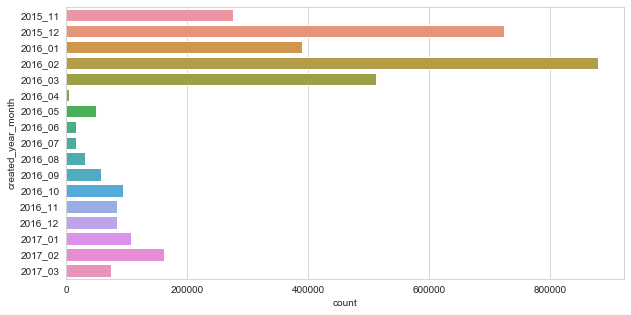

In [253]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['created_year_month'])
plt.show()

As we can see above, the volumes of car ads per month vary, especially across March and Aprill 2016. This is presumably because scrapping method had been tuned up in that time. I decided to shorten the scraping timeframe window, as this should provide more coherent data and improve overall prediction accuracy.

In [254]:
df.groupby(['created_year_month'])['price_eur'].describe()

,count,mean,std,min,25%,50%,75%,max
created_year_month,,,,,,,,
2015_11,274925.0,1.233104e+04,3.697931e+05,0.04,1490.2300,5366.40,13404.00,1.000148e+08
2015_12,724271.0,2.202072e+04,7.204187e+05,0.04,3951.4800,10078.98,18010.66,3.404523e+08
2016_01,389107.0,1.813875e+04,4.169198e+05,370.10,4001.5200,10408.40,18866.69,1.000074e+08
2016_02,879196.0,6.528335e+06,4.071998e+09,370.10,5657.0825,11950.00,19990.00,2.706149e+12
2016_03,511399.0,1.644282e+04,2.899182e+05,370.10,4996.8200,11499.00,19790.00,1.001332e+08
2016_04,4297.0,1.439998e+04,3.580285e+04,370.10,2849.7400,6846.78,14208.29,5.464202e+05
2016_05,48869.0,1.126372e+04,1.914449e+04,370.10,2900.1100,7134.27,14803.81,1.715063e+06
2016_06,15497.0,7.837597e+03,9.455459e+03,370.10,2775.7200,5514.43,9992.56,2.960400e+05
2016_07,15898.0,7.467093e+03,8.804289e+03,370.10,2775.7200,5181.31,9215.40,2.331606e+05


Eventually the scraped period will get limited to January 2016 - March 2016, as further scrapings do not show variance in the predicted variable (price_eur).

In [255]:
df = df[df['created_year_month'].between('2016_01','2016_03')]
df.to_csv('.\Cars_Jan_Mar_2016.csv')

******************************


# 2. Data preparation

In [142]:
df = pd.read_csv('./Cars_Jan_Mar_2016.csv', sep=',', low_memory=False, index_col=[0])

In [143]:
df.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur,year,month,created_year_month
1258599,hyundai,i10,44373.0,2011.0,1086.0,49.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.351263+00,2016-07-03 18:07:57.593938+00,5900.22,2016,1,2016_01
1258590,fiat,NaN,149000.0,2000.0,1900.0,NaN,NaN,NaN,None,man,4,None,diesel,2016-01-15 23:48:00.139562+00,2016-01-20 09:03:13.640667+00,1999.07,2016,1,2016_01
1258602,audi,a1,79850.0,2011.0,1390.0,90.0,NaN,NaN,None,auto,2,4,gasoline,2016-01-15 23:48:18.44457+00,2016-07-03 18:08:03.813917+00,11990.45,2016,1,2016_01
1258603,hyundai,i10,25.0,2016.0,998.0,49.0,NaN,NaN,None,auto,4,5,gasoline,2016-01-15 23:48:18.473834+00,2016-07-03 18:08:18.223965+00,9235.34,2016,1,2016_01
1258600,hyundai,i20,50785.0,2012.0,1248.0,63.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.38062+00,2016-07-03 18:08:02.791752+00,8450.30,2016,1,2016_01


In [144]:
raw_len = len(df)
print(raw_len)

1779702


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779702 entries, 1258599 to 2437959
Data columns (total 19 columns):
maker                  object
model                  object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
body_type              object
color_slug             object
stk_year               object
transmission           object
door_count             object
seat_count             object
fuel_type              object
date_created           object
date_last_seen         object
price_eur              float64
year                   int64
month                  int64
created_year_month     object
dtypes: float64(5), int64(2), object(12)
memory usage: 271.6+ MB


In [146]:
df.columns

Index(['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement',
       'engine_power', 'body_type', 'color_slug', 'stk_year', 'transmission',
       'door_count', 'seat_count', 'fuel_type', 'date_created',
       'date_last_seen', 'price_eur', 'year', 'month', 'created_year_month'],
      dtype='object')

Converting engine_power from kW to HP units, since I am better acquainted with HP metrics.

In [147]:
df['engine_power'] = 1.3410220888*df['engine_power']

Calculating the age of a car in a moment when the ad was scraped, instead of the manufacturing_year.

In [148]:
df['age_years'] = (df['year']-df['manufacture_year'])
df.drop(columns=['manufacture_year', 'year', 'month'], inplace=True)

Checking out the % share of null values across variables

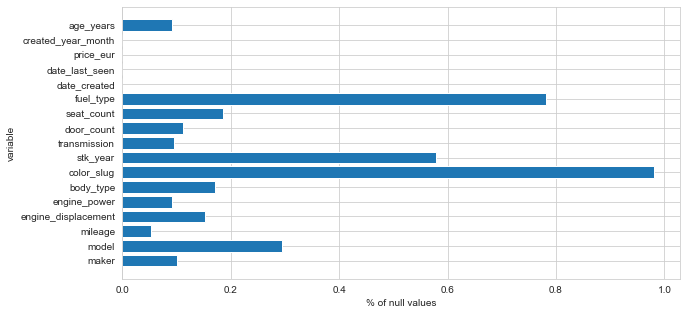

In [149]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

It seems that a number of variables have lot of missing values:

date_last_seen  - does not bring any useful information (as the policy was to remove all ads that had not been seen more than 60 days before scraping).

stk_year, color_slug  - variables that definitely need to be removed from the dataset because of missing values

In [150]:
df.drop(columns=['stk_year', 'color_slug', 'date_last_seen'], inplace=True)

Checking out fuel type as it is not present in most cases.

In [151]:
df['fuel_type'].value_counts()

gasoline    205837
diesel      183270
Name: fuel_type, dtype: int64

fuel_type should be important to predict the price but stands out in terms of missing values.
However, it can not be easily imputed, since the same engine capacities can ran with different fuel. Therefore I also decided to drop the variable. I will not be helpful in accordance to new car records.

In [152]:
df.drop(columns='fuel_type', inplace=True)

If no maker, model or manufacture_year is present in the dataset, we can not say if the price prediction is correct. These cases will also get dropped.

In [153]:
df.dropna(subset=['maker', 'model', 'age_years'], inplace=True)

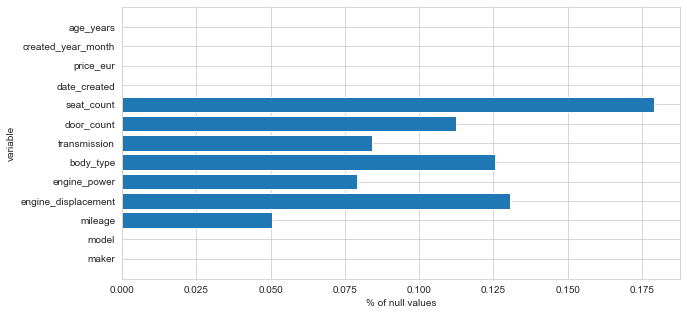

In [154]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

In [155]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1258599,hyundai,i10,44373.0,1086.0,65.710082,NaN,man,4,5,2016-01-15 23:48:18.351263+00,5900.22,2016_01,5.0
1258602,audi,a1,79850.0,1390.0,120.691988,NaN,auto,2,4,2016-01-15 23:48:18.44457+00,11990.45,2016_01,5.0
1258603,hyundai,i10,25.0,998.0,65.710082,NaN,auto,4,5,2016-01-15 23:48:18.473834+00,9235.34,2016_01,0.0
1258600,hyundai,i20,50785.0,1248.0,84.484392,NaN,man,4,5,2016-01-15 23:48:18.38062+00,8450.30,2016_01,4.0
1258601,hyundai,santa-fe,14487.0,2199.0,194.448203,NaN,auto,4,5,2016-01-15 23:48:18.410752+00,27901.04,2016_01,4.0


### Filtering out the outlier values

The variables present a lot of variance. Some values are out of the reasonable range. See the table below:

In [156]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.081564e+06,990232.000000,1.048723e+06,1.138866e+06,1.138866e+06
mean,9.902788e+04,1814.424140,1.232749e+02,6.879184e+04,8.826922e+00
std,2.633064e+05,1342.416534,5.987303e+01,2.795810e+07,4.388576e+01
min,0.000000e+00,1.000000,2.682044e+00,3.701000e+02,0.000000e+00
25%,2.150000e+04,1389.000000,8.850746e+01,4.600000e+03,2.000000e+00
50%,7.679950e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.385000e+05,1968.000000,1.408073e+02,1.697000e+04,1.000000e+01
max,9.999999e+06,32000.000000,2.016897e+03,1.492235e+10,2.016000e+03


The dataset obiously shows outliers. I decided to trim 0.5 percentile values on each edge of a variable.
The outliers will be replaced with np.nan values and imputed in further steps.

In [157]:
for i in df.describe().columns:
    df[i] = np.where(df[i].between(df[i].quantile(q=0.005), df[i].quantile(q=0.995)), df[i], np.nan)

In [158]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.076156e+06,980509.000000,1.039204e+06,1.127484e+06,1.133362e+06
mean,8.757411e+04,1746.097122,1.216716e+02,1.239726e+04,6.744254e+00
std,7.429605e+04,607.581520,5.250845e+01,1.070496e+04,5.721709e+00
min,0.000000e+00,800.000000,4.961782e+01,5.181300e+02,0.000000e+00
25%,2.128600e+04,1390.000000,8.850746e+01,4.663210e+03,2.000000e+00
50%,7.600000e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.372500e+05,1968.000000,1.408073e+02,1.690000e+04,1.000000e+01
max,3.723460e+05,6800.000000,4.237630e+02,8.032500e+04,4.500000e+01


We will next attempt to drop outliers for door_count and seat_count, as both variables are strings.

In [159]:
df[['door_count', 'seat_count']] = df[['door_count', 'seat_count']].replace('None', np.nan).apply(pd.to_numeric)

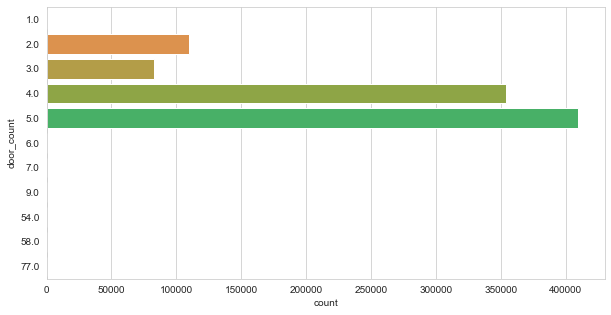

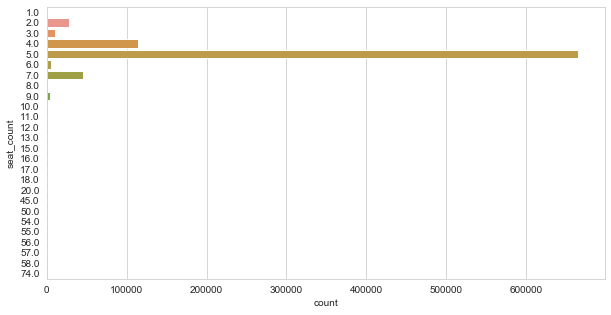

In [160]:
for i in ['door_count', 'seat_count']:
    plt.figure(figsize=(10,5))
    sns.countplot(y=df[i])
    plt.show()

Droping cars with atypical door count and seat count, since data scraped should include regular cars only.

In [161]:
df = df[df['door_count'].between(2,5)]

In [162]:
df = df[df['seat_count'].between(2,7)]

### Imputing missing values with means and mode for groups

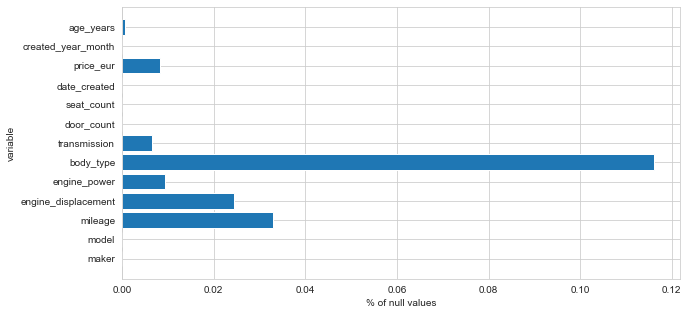

In [163]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

Inputing millage with mean in accordance to age of a car

In [164]:
df['mileage'] = df['mileage'].fillna(df.groupby(['age_years'])['mileage'].transform('mean'))

Imputing engine_power, engine_displacement, seat_count and transmission with a mode for model and manufacture_year

In [165]:
vars = ['seat_count', 'transmission', 'engine_power', 'engine_displacement']
for i in vars:
    df[i] = df.groupby(['model'])[i].transform(lambda x: x.fillna(x.mode()))

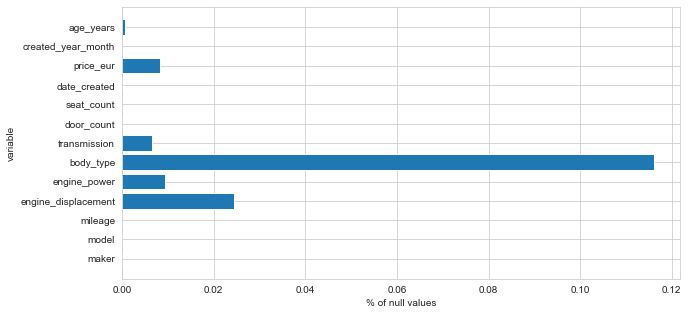

In [166]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

As we have reached serious imporovement in data quality, let's remove the records with missing values.

In [167]:
df.dropna(inplace=True)

In [168]:
len(df), len(df)/raw_len

(704326, 0.39575501966059484)

<b>The cleaned dataset consists now of <font color=blue> 704 326 </font>cars, that is <font color=blue>40% </font> of the initial file for the specified period.

### Checking outh distributions of the dimension variables

In [169]:
df['body_type'].value_counts(normalize=True)

other          0.983840
compact        0.007066
van            0.004972
convertible    0.001400
coupe          0.001374
transporter    0.001347
Name: body_type, dtype: float64

The category 'other' is prevailing over the body_type variable. The value of this variable is doubtful since 'other' includes most brands and models (SUV cars, truckts, as well as small compact cars). 

In [170]:
df[df['body_type']=='other'].head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1260447,audi,q3,63933.0,1968.0,174.332872,other,auto,4.0,5.0,2016-01-16 01:34:02.783133+00,27990.0,2016_01,4.0
1256544,toyota,yaris,14.0,1364.0,88.507458,other,man,5.0,5.0,2016-01-15 22:12:36.407341+00,13900.0,2016_01,1.0
1264644,mazda,cx-7,113916.0,2261.0,256.135219,other,man,4.0,5.0,2016-01-16 06:08:28.84931+00,9300.0,2016_01,8.0
1263957,hyundai,santa-fe,156559.0,2656.0,186.402070,other,man,5.0,5.0,2016-01-16 05:36:51.790394+00,5250.0,2016_01,9.0
1265522,nissan,qashqai,122105.0,1461.0,108.622789,other,man,5.0,5.0,2016-01-16 07:49:49.913239+00,12350.0,2016_01,5.0


In [171]:
df.drop(columns='body_type', inplace=True)

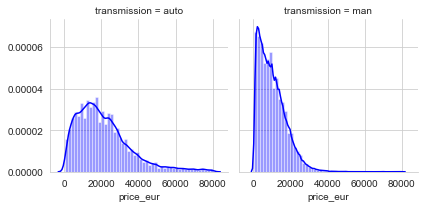

In [172]:
ax = sns.FacetGrid(data=df,col='transmission')
ax.map(sns.distplot, 'price_eur', color='blue')
plt.show()

It also seems that price distributions vs. transmission differ, so this variable will be included in modelling.

*************************

### Sampling the data frame to speed up modeling

<b> Before we go further with modeling I will make a sample of the dataset. This will speed up the learning process.

In [173]:
# original data size in volume and as % of raw dataframe.
len(df), len(df)/raw_len

(704326, 0.39575501966059484)

In [174]:
df = df.sample(n=50000, random_state=random_seed).reset_index(drop=True)

In [175]:
len(df)

50000

In [176]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
0,seat,altea,89000.0,1598.0,103.258701,man,5.0,5.0,2016-02-17 12:51:29.570457+00,11900.0,2016_02,5.0
1,ford,focus,100000.0,1560.0,107.281767,man,5.0,5.0,2016-02-21 18:48:04.139541+00,7500.0,2016_02,5.0
2,suzuki,swift,163000.0,1248.0,68.392127,man,3.0,4.0,2016-03-09 16:59:32.12635+00,2900.0,2016_03,9.0
3,mercedes-benz,vito,112561.0,2148.0,93.871546,man,4.0,3.0,2016-03-07 11:19:14.522007+00,12900.0,2016_03,6.0
4,porsche,panamera,41059.0,2967.0,296.365882,auto,4.0,4.0,2016-02-12 10:48:18.152636+00,58004.0,2016_02,2.0


In [177]:
numeric_cols = ['price_eur' , 'age_years', 'mileage', 'engine_displacement', 'engine_power'] 

The graph below shows that there is a big variance over car metrics. We can see the presence of outlier values.

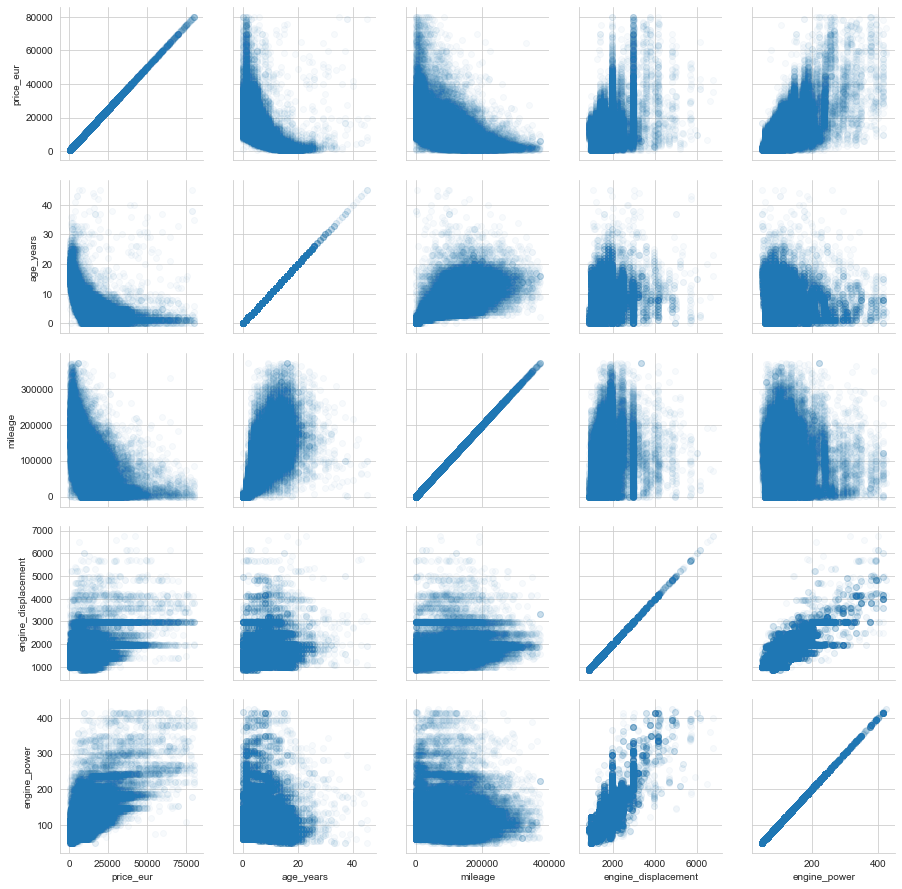

In [178]:
graph = sns.PairGrid(df[numeric_cols])
graph.map(plt.scatter, alpha=0.03)
plt.show()

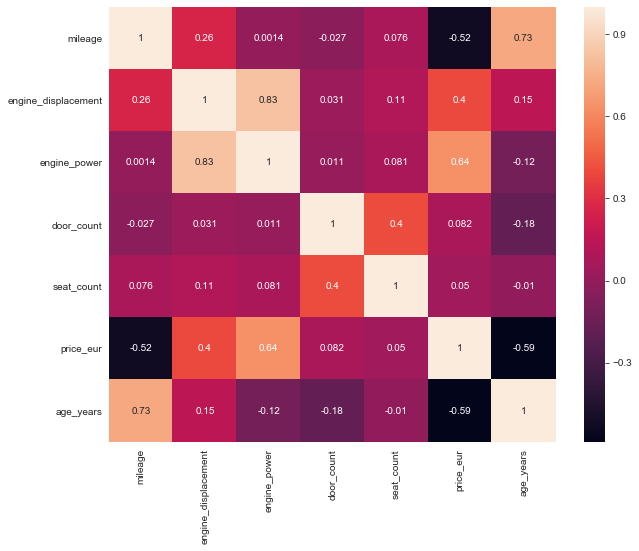

In [179]:
# Using Pearson Correlation Matrix
fig = plt.figure(figsize=(10,8))
cor = df.corr()
ax = sns.heatmap(cor, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Apart from:
- engine_power vs. engine_displacement (cor=0.82,  
- mileage vs. age_years (cor=0.73)
- price_eur vs. engine_power (cor=0.64)

there is no other significant correlation between metrics. 

*************************

## Attempt to cluster cars before modelling

<b> Since we dropped much of categorical data in order predict car prices I will attempt to cluster cars into some homogenic groups. If the clustering will go fine, the clusters will be considered in furher price predictions, if not I will skip this step and go on with modeling section with no additional information about clusters.

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

Please note that due to manufacturer downsizing the same engine_displacement can result in completely different engine_power in accordance to age and make of a car.

In [181]:
# an expample how engine_power varies across the same engine_displacement
df['engine_power'][df['engine_displacement'].between(1490,1495)].describe()

count     62.000000
mean      95.126051
std       11.996607
min       67.051104
25%       87.501691
50%       95.883079
75%      107.281767
max      112.645855
Name: engine_power, dtype: float64

In [182]:
data_for_clustering = df[['engine_power', 'seat_count']]
data_for_clustering.head()

,engine_power,seat_count
0,103.258701,5.0
1,107.281767,5.0
2,68.392127,4.0
3,93.871546,3.0
4,296.365882,4.0


In [183]:
#MiniBatchClustering
data_clustered = StandardScaler().fit_transform(data_for_clustering)

clusters = range(2, 15)
silhouette = []
inertia  = []
for k in clusters:
    
    model = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=random_seed)
    
    model.fit(data_clustered)
    
    silhouette.append(silhouette_score(data_clustered, model.predict(data_clustered)))
    inertia.append(model.inertia_)

Plotting Silhouette and Inertia scores to set up optimal number of clusters:

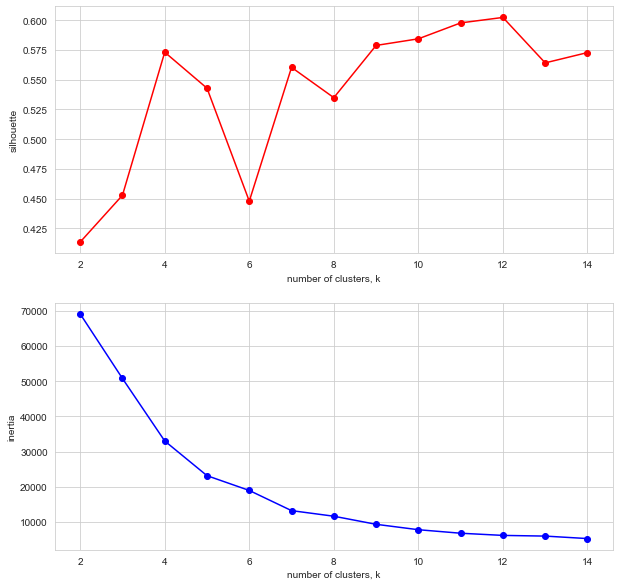

In [184]:
# Plot clusters vs silhouette
plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(clusters, silhouette, 'r-o', )
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')

plt.subplot(2, 1, 2)
# Plot clusters vs silhouette
plt.plot(clusters, inertia, 'b-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')

plt.show()

The optimal values out of the specified cluster range is 6.

In [185]:
cluster_model = MiniBatchKMeans(n_clusters=12)
cluster_model.fit(data_clustered)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=12, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [186]:
df['cluster']=cluster_model.predict(data_clustered)

In [187]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
0,seat,altea,89000.0,1598.0,103.258701,man,5.0,5.0,2016-02-17 12:51:29.570457+00,11900.0,2016_02,5.0,11
1,ford,focus,100000.0,1560.0,107.281767,man,5.0,5.0,2016-02-21 18:48:04.139541+00,7500.0,2016_02,5.0,11
2,suzuki,swift,163000.0,1248.0,68.392127,man,3.0,4.0,2016-03-09 16:59:32.12635+00,2900.0,2016_03,9.0,6
3,mercedes-benz,vito,112561.0,2148.0,93.871546,man,4.0,3.0,2016-03-07 11:19:14.522007+00,12900.0,2016_03,6.0,8
4,porsche,panamera,41059.0,2967.0,296.365882,auto,4.0,4.0,2016-02-12 10:48:18.152636+00,58004.0,2016_02,2.0,7


In [188]:
df['cluster'].value_counts()

11    11607
9      9427
5      8267
1      6514
6      3594
4      2834
0      2261
10     1670
3      1248
2      1175
7       839
8       564
Name: cluster, dtype: int64

In [189]:
groups = df.groupby(by='cluster')['price_eur', 'engine_power', 'seat_count', 'door_count', 'age_years'].mean()

Check out how the clusters are formed:

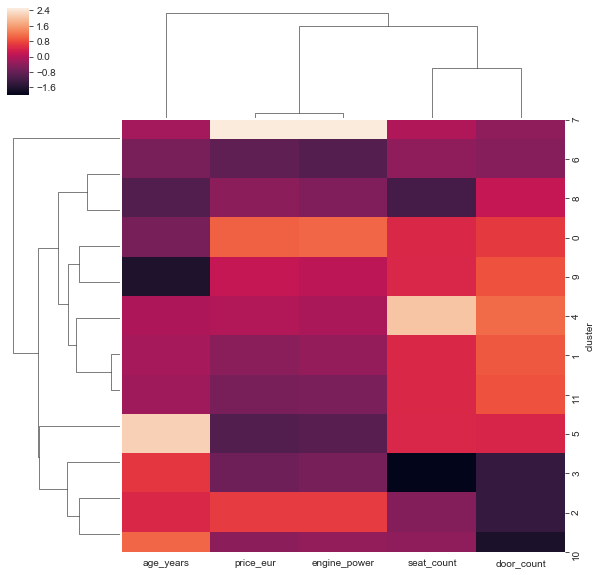

In [190]:
sns.clustermap(groups, z_score=1)
plt.show()

In [191]:
print(groups)

            price_eur  engine_power  seat_count  door_count  age_years
cluster                                                               
0        25002.095290    226.042588    5.014595    4.263158   6.025210
1        11600.723000    121.662448    5.009518    4.460854   6.458858
2        21897.475983    196.622371    3.840851    2.820426   6.988085
3         8928.338229     97.566879    2.000000    2.816506   7.133814
4        15479.169936    139.020552    6.962950    4.592802   6.521877
5         5891.961141     72.330355    5.001573    4.099552   8.525221
6         7377.664343     70.551045    4.000000    3.458820   6.045910
7        38924.840453    335.925234    4.394517    3.533969   6.450536
8        11625.250301    105.446184    3.000000    3.920213   5.666667
9        17332.094635    153.389626    5.004455    4.428238   5.144479
10       11738.831371    120.512114    4.000000    2.601198   7.518563
11        9901.562360    100.403469    5.006548    4.430430   6.399845


As we can see below one car model falls into several clusters, whis is not what we would like to accept, since prices are rather differentiated in accordance to models. Have a look ford mondeo, which falls into two clusters 5 and 0:

In [192]:
df[(df['maker']=='ford') & (df['model']=='mondeo')]

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
594,ford,mondeo,225000.0,1796.0,113.986878,man,5.0,5.0,2016-02-18 21:14:55.401806+00,750.00,2016_02,18.0,1
994,ford,mondeo,27480.0,1997.0,177.014916,auto,4.0,5.0,2016-03-09 12:07:20.833907+00,28489.00,2016_03,1.0,9
1059,ford,mondeo,223000.0,1597.0,93.871546,man,4.0,5.0,2016-03-02 10:39:38.320086+00,690.93,2016_03,16.0,11
1065,ford,mondeo,53806.0,1997.0,160.922651,man,5.0,5.0,2016-02-12 10:59:05.024831+00,17930.00,2016_02,3.0,9
1183,ford,mondeo,158000.0,2198.0,152.876518,man,5.0,5.0,2016-02-23 14:48:50.473107+00,4999.00,2016_02,11.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49779,ford,mondeo,171770.0,1998.0,128.738121,man,5.0,5.0,2016-03-14 09:05:00.253676+00,1406.37,2016_03,13.0,1
49799,ford,mondeo,247000.0,1798.0,123.374032,man,5.0,5.0,2016-03-06 21:40:54.235665+00,1500.00,2016_03,14.0,1
49811,ford,mondeo,43000.0,1997.0,138.125275,man,4.0,5.0,2016-03-10 03:38:30.625903+00,16490.00,2016_03,3.0,9
49822,ford,mondeo,119000.0,1999.0,143.489364,man,5.0,5.0,2016-02-14 18:52:50.706303+00,6999.00,2016_02,9.0,9


Despite that I will inlude clusters in the modelling proces, since had previously dropped a few categorical variables due to data quality.

In [193]:
df.to_csv('.\Cars_sample_cleaned_50k.csv')

***************

## 3. Modeling car prices

### Defining target variable and split dataset into training and testing set

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

from sklearn import  metrics

Using TensorFlow backend.


In [3]:
df = pd.read_csv('./Cars_sample_cleaned_50k.csv', sep=',', low_memory=False, index_col=[0])

In [4]:
df.shape

(50000, 13)

In [5]:
df.columns

Index(['maker', 'model', 'mileage', 'engine_displacement', 'engine_power',
       'transmission', 'door_count', 'seat_count', 'date_created', 'price_eur',
       'created_year_month', 'age_years', 'cluster'],
      dtype='object')

In [6]:
df.dtypes

maker                   object
model                   object
mileage                float64
engine_displacement    float64
engine_power           float64
transmission            object
door_count             float64
seat_count             float64
date_created            object
price_eur              float64
created_year_month      object
age_years              float64
cluster                  int64
dtype: object

In [7]:
df['transmission'].value_counts()

man     39389
auto    10611
Name: transmission, dtype: int64

In [8]:
df['transmission'] = df['transmission'].apply(lambda x: 0 if (x=='man') else 1) 

In [9]:
cat_variables = ['door_count', 'seat_count', 'cluster']

for i in cat_variables:
    df[i] = df[i].astype('category')

In a series of experiments it turned out that cluster did not increase prediction accuracy, so I decide to drop it.

In [10]:
y = df['price_eur']
X = df.drop(['maker', 'model', 'price_eur', 'date_created', 'created_year_month', 'cluster'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [12]:
X.head()

,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,age_years
0,89000.0,1598.0,103.258701,0,5.0,5.0,5.0
1,100000.0,1560.0,107.281767,0,5.0,5.0,5.0
2,163000.0,1248.0,68.392127,0,3.0,4.0,9.0
3,112561.0,2148.0,93.871546,0,4.0,3.0,6.0
4,41059.0,2967.0,296.365882,1,4.0,4.0,2.0


### Setting up kfold cross-validation criteria

In [13]:
kfold = model_selection.KFold(n_splits=5, random_state=random_seed)

### Specifing pipeline

Creating the preprocessing pipeline for both numeric and categorical data, and separately for each type to use it across models.

In [14]:
numeric_features = ['mileage', 'engine_displacement','engine_power', 'age_years']
# since tranmission is coded 0/1 now, there is no need to scale it.
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['door_count', 'seat_count' ] 
#'cluster' - I decided to drop it from computations since it did not improve the score.
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

num_preprocessor_only = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])

cat_preprocessor_only = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])


##  Polynomial linear regression

In [38]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4]}

lm_1 = GridSearchCV(
    make_pipeline(#cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction
                  PolynomialFeatures(degree=2), 
                  linear_model.LinearRegression()),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'polynomialfeatures__degr

In [39]:
print(lm_1.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_1.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_1.predict(X_test)))

{'polynomialfeatures__degree': 3} 
R2: 0.861087876530106 
MAE: 2473.562660566353


## Polynomial linear regression - ridge regularization 

In [40]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
            'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

lm_2_rr = GridSearchCV(
    make_pipeline(#cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction
                  PolynomialFeatures(degree=2), 
                  linear_model.Ridge(random_state=random_seed)),
    param_grid=param_grid,  
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_2_rr.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.09101e-36): result may not be accurate.
  overwrite_a=True).T


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False, random_state=42,
                                              solver='auto', tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'polynomialfeatures__deg

In [41]:
print(lm_2_rr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_2_rr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_2_rr.predict(X_test)))

{'polynomialfeatures__degree': 3, 'ridge__alpha': 1} 
R2: 0.8681235749557445 
MAE: 2393.493446753084


## Polynomial linear regression - lasso regularization

In [42]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
            'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

lm_3_lr = GridSearchCV(
    make_pipeline(
        #cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction 
        PolynomialFeatures(degree=2), linear_model.Lasso(random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_3_lr.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287662985334.1047, tolerance: 432220144.7803217
  positive)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=42,
                                              selection='cyclic', tol=0.0001,
                                              warm_start

In [43]:
print(lm_3_lr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_3_lr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_3_lr.predict(X_test)))

{'lasso__alpha': 0.1, 'polynomialfeatures__degree': 4} 
R2: 0.8689808809309374 
MAE: 2374.464748423079


## Polymomial linear regression - elasticnet regularization

In [44]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
            'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lm_4_en = GridSearchCV(
    make_pipeline(
        #cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction 
        PolynomialFeatures(degree=2), linear_model.ElasticNet(alpha=1, random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_4_en.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287698533925.5381, tolerance: 432220144.7803217
  positive)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('elasticnet',
                                        ElasticNet(alpha=1, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
            

In [45]:
print(lm_4_en.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_4_en.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_4_en.predict(X_test)))

{'elasticnet__alpha': 0.001, 'polynomialfeatures__degree': 4} 
R2: 0.868972750388058 
MAE: 2374.7184155324967


## Support Vector Regression

In [46]:
# This part was skipped due to the fact that algorithm did not manage to train the model within 12 hours.

In [47]:
# pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), ('SVR', SVR(kernel='rbf'))])

# param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only), None],
#               'SVR__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'SVR__C': [1, 10, 100, 1000, 10000, 20000]}

# svr_5 = GridSearchCV(pipe, 
#                      param_grid, 
#                      cv=kfold, 
#                      return_train_score=True,
#                      n_jobs=-1)

# svr_5.fit(X_train, y_train)

In [48]:
# print(svr_5.best_params_, 
#       '\nR2:', metrics.r2_score(y_test, svr_5.predict(X_test)), 
#       '\nMAE:', metrics.mean_absolute_error(y_test, svr_5.predict(X_test)))

## Random forest regression

In [49]:
param_grid = {'n_estimators': [100, 200, 500, 700],
              'max_depth':  [20, 50, 100, 200],  
              'max_features': ['log2','sqrt','auto'],
              'max_leaf_nodes':  [100, 200, 300, 500, 700]}

rfr = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=50, 
                            oob_score = True, random_state=random_seed)
                 
rfr_6 = GridSearchCV(rfr,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

rfr_6.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=True, random_state=42,
                                             verbose=0,

In [50]:
print(rfr_6.best_params_, 
      '\nR2:', metrics.r2_score(y_test, rfr_6.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, rfr_6.predict(X_test)))

{'max_depth': 50, 'max_features': 'log2', 'max_leaf_nodes': 700, 'n_estimators': 500} 
R2: 0.903516625975581 
MAE: 2075.8470893130393


Printing out feature importances for RFR model:

In [51]:
feat_importances = pd.Series(data=rfr_6.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=True)

In [52]:
feat_importances.index

Index(['door_count', 'seat_count', 'transmission', 'engine_displacement',
       'mileage', 'engine_power', 'age_years'],
      dtype='object')

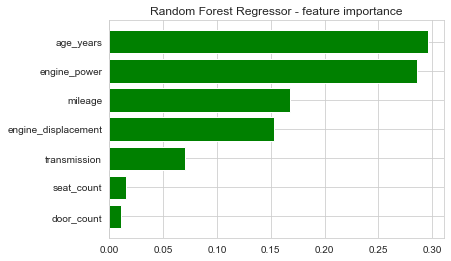

In [53]:
plt.barh(feat_importances.index, feat_importances.values, color='green')
plt.title('Random Forest Regressor - feature importance')
plt.show()

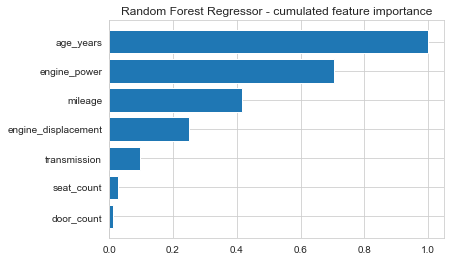

In [54]:
plt.barh(feat_importances.index, feat_importances.values.cumsum())
plt.title('Random Forest Regressor - cumulated feature importance')
plt.show()

As it was shown in the correlation matrix the most important features to predict car prices is age power, engine_displacement and mileage. The remaining predictors are of minor imporance.

## Gradient Boosting Regressor

In [55]:
pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), 
                 ('GBR', GradientBoostingRegressor(loss='ls', n_estimators=50, random_state=random_seed))])

param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only), None],
              'GBR__n_estimators': [50, 100, 200, 500, 700]
             }

gbr_7 = GridSearchCV(pipe,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

gbr_7.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        Pipeline(memory=None,
                                                 steps=[('columntransformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('num',
                                                                                          Pipeline(memory=None,
                                                                         

In [56]:
print(gbr_7.best_params_, 
      '\nR2:', metrics.r2_score(y_test, gbr_7.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, gbr_7.predict(X_test)))

{'GBR__n_estimators': 700, 'preprocessing': None} 
R2: 0.9097247445551276 
MAE: 1988.8117028795245


## Neural Network Keras Regressor

In [57]:
full_preprocessor.fit_transform(X_test).shape

(10000, 14)

In [59]:
def build_regressor():
    model = Sequential()
    model.add(Dense(14, input_shape=(14,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(42, kernel_initializer='normal', activation='relu'))
    model.add(Dense(28, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss="mse", optimizer="adam", metrics=['mae'])
    print(model.summary())
    return model

early_stopping = EarlyStopping(monitor='loss', patience=10)

Keras_Regressor_model = KerasRegressor(build_fn=build_regressor, 
                                       epochs=500, 
                                       batch_size=20, 
                                       verbose=2)

pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)),
                     ('KR', Keras_Regressor_model)])           


param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only)],
              'KR__batch_size': [20, 32, 50]}

kerasNNR_8 = GridSearchCV(pipe,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=1)

kerasNNR_8.fit(X_train, y_train)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_146 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_147 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_148 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 - 2s - loss: 77199026.5372 - mae: 5288.8882
Epoch 2/500
 - 2s - loss: 24109508.7445 - mae: 3061.4231
Epoch 3/500
 - 2s - loss: 22644242.8114 - mae: 2905.9382
Epoch 4/500
 - 3s - loss: 21847927.9452 - mae: 2846.0742
Epoch 5/500
 - 2

Epoch 127/500
 - 2s - loss: 18326426.0180 - mae: 2607.1472
Epoch 128/500
 - 2s - loss: 18330014.5191 - mae: 2608.4792
Epoch 129/500
 - 2s - loss: 18335480.6513 - mae: 2606.1006
Epoch 130/500
 - 2s - loss: 18345014.9116 - mae: 2613.8130
Epoch 131/500
 - 2s - loss: 18360439.9796 - mae: 2605.8857
Epoch 132/500
 - 2s - loss: 18327187.5944 - mae: 2607.2998
Epoch 133/500
 - 2s - loss: 18346734.8945 - mae: 2609.9417
Epoch 134/500
 - 2s - loss: 18338018.4743 - mae: 2610.2568
Epoch 135/500
 - 2s - loss: 18334757.7453 - mae: 2608.3491
Epoch 136/500
 - 2s - loss: 18345478.9177 - mae: 2610.5244
Epoch 137/500
 - 2s - loss: 18311468.4005 - mae: 2606.2341
Epoch 138/500
 - 2s - loss: 18296417.3295 - mae: 2607.5530
Epoch 139/500
 - 2s - loss: 18325544.7980 - mae: 2606.4685
Epoch 140/500
 - 2s - loss: 18310376.0751 - mae: 2608.2407
Epoch 141/500
 - 2s - loss: 18347474.0163 - mae: 2607.4353
Epoch 142/500
 - 2s - loss: 18285865.6382 - mae: 2607.8630
Epoch 143/500
 - 2s - loss: 18304089.0368 - mae: 2606.73

Epoch 266/500
 - 2s - loss: 18132236.6898 - mae: 2598.6470
Epoch 267/500
 - 2s - loss: 18129194.9070 - mae: 2600.2126
Epoch 268/500
 - 2s - loss: 18113286.0595 - mae: 2598.7639
Epoch 269/500
 - 2s - loss: 18143722.1252 - mae: 2597.0598
Epoch 270/500
 - 2s - loss: 18109066.1695 - mae: 2596.4900
Epoch 271/500
 - 2s - loss: 18134801.8838 - mae: 2600.0371
Epoch 272/500
 - 2s - loss: 18108383.4405 - mae: 2599.8174
Epoch 273/500
 - 2s - loss: 18140312.0738 - mae: 2600.2456
Epoch 274/500
 - 2s - loss: 18103513.7382 - mae: 2595.7852
Epoch 275/500
 - 2s - loss: 18127671.8248 - mae: 2600.9727
Epoch 276/500
 - 2s - loss: 18090181.9143 - mae: 2596.1709
Epoch 277/500
 - 2s - loss: 18101176.9448 - mae: 2598.3057
Epoch 278/500
 - 2s - loss: 18115666.5182 - mae: 2596.7317
Epoch 279/500
 - 2s - loss: 18114259.8019 - mae: 2598.7773
Epoch 280/500
 - 2s - loss: 18115288.9655 - mae: 2597.0718
Epoch 281/500
 - 2s - loss: 18114078.8372 - mae: 2601.0684
Epoch 282/500
 - 2s - loss: 18122197.9870 - mae: 2598.38

Epoch 405/500
 - 2s - loss: 17993732.3901 - mae: 2589.3008
Epoch 406/500
 - 2s - loss: 17984738.1536 - mae: 2588.2244
Epoch 407/500
 - 2s - loss: 18006555.4028 - mae: 2592.9597
Epoch 408/500
 - 2s - loss: 17987087.8748 - mae: 2591.3870
Epoch 409/500
 - 2s - loss: 17986863.7817 - mae: 2587.4326
Epoch 410/500
 - 2s - loss: 18010440.7705 - mae: 2589.2053
Epoch 411/500
 - 2s - loss: 17949179.6855 - mae: 2589.1216
Epoch 412/500
 - 2s - loss: 17993401.2384 - mae: 2589.1526
Epoch 413/500
 - 2s - loss: 17949146.2340 - mae: 2589.2141
Epoch 414/500
 - 2s - loss: 17979249.8252 - mae: 2587.4744
Epoch 415/500
 - 2s - loss: 18018661.4267 - mae: 2591.3208
Epoch 416/500
 - 2s - loss: 17977364.3997 - mae: 2588.7539
Epoch 417/500
 - 2s - loss: 17949892.9033 - mae: 2590.4490
Epoch 418/500
 - 2s - loss: 17999670.2502 - mae: 2586.4475
Epoch 419/500
 - 2s - loss: 18007300.9564 - mae: 2587.5557
Epoch 420/500
 - 2s - loss: 17930961.0345 - mae: 2589.2493
Epoch 421/500
 - 2s - loss: 17980420.4791 - mae: 2585.92

Epoch 30/500
 - 2s - loss: 18878215.4889 - mae: 2625.7266
Epoch 31/500
 - 2s - loss: 18806286.8823 - mae: 2615.4744
Epoch 32/500
 - 2s - loss: 18713382.8077 - mae: 2608.4597
Epoch 33/500
 - 2s - loss: 18590036.9767 - mae: 2600.2131
Epoch 34/500
 - 2s - loss: 18432153.3482 - mae: 2588.1313
Epoch 35/500
 - 2s - loss: 18206278.1155 - mae: 2566.4238
Epoch 36/500
 - 2s - loss: 17955207.2469 - mae: 2562.8740
Epoch 37/500
 - 2s - loss: 17853896.8082 - mae: 2567.3875
Epoch 38/500
 - 2s - loss: 17789850.7015 - mae: 2566.3062
Epoch 39/500
 - 2s - loss: 17703455.3112 - mae: 2564.9126
Epoch 40/500
 - 2s - loss: 17661745.9612 - mae: 2561.3433
Epoch 41/500
 - 2s - loss: 17626496.5447 - mae: 2563.4771
Epoch 42/500
 - 2s - loss: 17556222.7155 - mae: 2561.4172
Epoch 43/500
 - 2s - loss: 17513429.1901 - mae: 2557.7290
Epoch 44/500
 - 2s - loss: 17486583.1457 - mae: 2555.2349
Epoch 45/500
 - 2s - loss: 17445823.0744 - mae: 2556.7937
Epoch 46/500
 - 2s - loss: 17381027.9236 - mae: 2550.8787
Epoch 47/500
 

 - 2s - loss: 15449662.9747 - mae: 2438.0396
Epoch 171/500
 - 2s - loss: 15462141.6216 - mae: 2437.8704
Epoch 172/500
 - 2s - loss: 15422121.0586 - mae: 2436.4548
Epoch 173/500
 - 2s - loss: 15443099.4512 - mae: 2433.7866
Epoch 174/500
 - 2s - loss: 15433293.7458 - mae: 2435.4561
Epoch 175/500
 - 2s - loss: 15403420.2379 - mae: 2434.7383
Epoch 176/500
 - 2s - loss: 15392060.9313 - mae: 2432.5576
Epoch 177/500
 - 2s - loss: 15401917.4852 - mae: 2433.4849
Epoch 178/500
 - 2s - loss: 15397172.4916 - mae: 2433.6699
Epoch 179/500
 - 2s - loss: 15390837.1030 - mae: 2433.4153
Epoch 180/500
 - 2s - loss: 15370485.3628 - mae: 2432.1599
Epoch 181/500
 - 2s - loss: 15357427.1542 - mae: 2430.0427
Epoch 182/500
 - 2s - loss: 15369200.3272 - mae: 2430.6877
Epoch 183/500
 - 2s - loss: 15369085.4905 - mae: 2430.8723
Epoch 184/500
 - 2s - loss: 15324190.7405 - mae: 2427.9377
Epoch 185/500
 - 2s - loss: 15316962.6935 - mae: 2426.7559
Epoch 186/500
 - 2s - loss: 15315750.0666 - mae: 2428.1206
Epoch 187/5

 - 2s - loss: 14105160.7878 - mae: 2374.0322
Epoch 310/500
 - 2s - loss: 14134869.7788 - mae: 2374.2429
Epoch 311/500
 - 2s - loss: 14076119.5368 - mae: 2368.3755
Epoch 312/500
 - 2s - loss: 14101869.7052 - mae: 2369.5129
Epoch 313/500
 - 2s - loss: 14090033.8531 - mae: 2368.8972
Epoch 314/500
 - 2s - loss: 14090632.5402 - mae: 2371.2102
Epoch 315/500
 - 2s - loss: 14074602.0744 - mae: 2371.3552
Epoch 316/500
 - 2s - loss: 14064489.2959 - mae: 2370.4407
Epoch 317/500
 - 2s - loss: 14073264.1742 - mae: 2371.2944
Epoch 318/500
 - 2s - loss: 14060988.3198 - mae: 2369.7842
Epoch 319/500
 - 2s - loss: 14077020.9705 - mae: 2370.2930
Epoch 320/500
 - 2s - loss: 14065290.1223 - mae: 2370.0859
Epoch 321/500
 - 2s - loss: 14032196.6941 - mae: 2366.2126
Epoch 322/500
 - 2s - loss: 14034023.6966 - mae: 2366.0247
Epoch 323/500
 - 2s - loss: 14000526.2055 - mae: 2365.4319
Epoch 324/500
 - 2s - loss: 14058595.0530 - mae: 2367.8711
Epoch 325/500
 - 2s - loss: 14053312.3407 - mae: 2367.6567
Epoch 326/5

 - 2s - loss: 13656010.7009 - mae: 2338.8147
Epoch 449/500
 - 2s - loss: 13641718.4913 - mae: 2342.5649
Epoch 450/500
 - 2s - loss: 13594007.3093 - mae: 2338.4604
Epoch 451/500
 - 2s - loss: 13640137.4069 - mae: 2338.6797
Epoch 452/500
 - 2s - loss: 13656931.0852 - mae: 2342.3250
Epoch 453/500
 - 2s - loss: 13669286.8097 - mae: 2341.7090
Epoch 454/500
 - 2s - loss: 13648245.8344 - mae: 2340.6741
Epoch 455/500
 - 2s - loss: 13635410.2759 - mae: 2341.6145
Epoch 456/500
 - 2s - loss: 13649765.9120 - mae: 2339.1560
Epoch 457/500
 - 2s - loss: 13611236.3666 - mae: 2339.4749
Epoch 458/500
 - 2s - loss: 13629700.1188 - mae: 2335.9412
Epoch 459/500
 - 2s - loss: 13619436.2759 - mae: 2338.9753
Epoch 460/500
 - 2s - loss: 13605172.1531 - mae: 2338.8669
Epoch 461/500
 - 2s - loss: 13632207.4948 - mae: 2339.7026
Epoch 462/500
 - 2s - loss: 13621915.5786 - mae: 2340.4087
Epoch 463/500
 - 2s - loss: 13655199.7263 - mae: 2338.1145
Epoch 464/500
 - 3s - loss: 13623506.8511 - mae: 2338.0867
Epoch 465/5

Epoch 74/500
 - 2s - loss: 17326869.3009 - mae: 2543.1582
Epoch 75/500
 - 2s - loss: 17335972.4077 - mae: 2545.4197
Epoch 76/500
 - 2s - loss: 17304499.0345 - mae: 2537.8237
Epoch 77/500
 - 2s - loss: 17288782.2721 - mae: 2538.8672
Epoch 78/500
 - 2s - loss: 17253295.3805 - mae: 2538.1746
Epoch 79/500
 - 2s - loss: 17256206.5200 - mae: 2537.6650
Epoch 80/500
 - 2s - loss: 17207442.8383 - mae: 2534.5271
Epoch 81/500
 - 2s - loss: 17216576.6726 - mae: 2534.1707
Epoch 82/500
 - 2s - loss: 17169147.1517 - mae: 2535.7275
Epoch 83/500
 - 2s - loss: 17148142.3489 - mae: 2531.5725
Epoch 84/500
 - 2s - loss: 17134419.8398 - mae: 2531.6111
Epoch 85/500
 - 2s - loss: 17111309.2851 - mae: 2525.2507
Epoch 86/500
 - 2s - loss: 17091197.8203 - mae: 2529.1960
Epoch 87/500
 - 2s - loss: 17032323.4670 - mae: 2524.3403
Epoch 88/500
 - 2s - loss: 17020845.2422 - mae: 2523.8674
Epoch 89/500
 - 2s - loss: 16997089.6633 - mae: 2522.5005
Epoch 90/500
 - 2s - loss: 16924456.0571 - mae: 2518.9299
Epoch 91/500
 

Epoch 214/500
 - 2s - loss: 15438197.0369 - mae: 2420.1836
Epoch 215/500
 - 2s - loss: 15453229.3282 - mae: 2421.7405
Epoch 216/500
 - 2s - loss: 15419299.9019 - mae: 2421.4092
Epoch 217/500
 - 2s - loss: 15426211.3851 - mae: 2422.0276
Epoch 218/500
 - 2s - loss: 15392838.5743 - mae: 2418.1455
Epoch 219/500
 - 2s - loss: 15394396.7806 - mae: 2418.1489
Epoch 220/500
 - 2s - loss: 15381960.9291 - mae: 2420.5249
Epoch 221/500
 - 2s - loss: 15407614.7460 - mae: 2419.7993
Epoch 222/500
 - 2s - loss: 15380285.5065 - mae: 2416.7305
Epoch 223/500
 - 2s - loss: 15399318.2572 - mae: 2417.9546
Epoch 224/500
 - 2s - loss: 15371019.6491 - mae: 2416.5474
Epoch 225/500
 - 2s - loss: 15394664.2423 - mae: 2418.0974
Epoch 226/500
 - 2s - loss: 15370098.6780 - mae: 2418.4595
Epoch 227/500
 - 2s - loss: 15348458.9893 - mae: 2417.0818
Epoch 228/500
 - 2s - loss: 15372462.1548 - mae: 2417.0669
Epoch 229/500
 - 2s - loss: 15369360.4177 - mae: 2418.3464
Epoch 230/500
 - 2s - loss: 15395032.3478 - mae: 2419.82

Epoch 353/500
 - 2s - loss: 14386761.4833 - mae: 2355.6833
Epoch 354/500
 - 2s - loss: 14371403.9451 - mae: 2352.5642
Epoch 355/500
 - 2s - loss: 14391212.1153 - mae: 2354.7454
Epoch 356/500
 - 2s - loss: 14352711.9213 - mae: 2354.8391
Epoch 357/500
 - 2s - loss: 14321634.3952 - mae: 2351.0503
Epoch 358/500
 - 2s - loss: 14360142.5912 - mae: 2353.5344
Epoch 359/500
 - 2s - loss: 14298572.8557 - mae: 2348.5237
Epoch 360/500
 - 2s - loss: 14353406.9433 - mae: 2353.1755
Epoch 361/500
 - 2s - loss: 14336863.0183 - mae: 2352.4094
Epoch 362/500
 - 2s - loss: 14294551.3245 - mae: 2348.8235
Epoch 363/500
 - 2s - loss: 14336434.7487 - mae: 2350.8687
Epoch 364/500
 - 2s - loss: 14292938.2214 - mae: 2350.2490
Epoch 365/500
 - 2s - loss: 14286054.2868 - mae: 2348.2339
Epoch 366/500
 - 2s - loss: 14306718.7945 - mae: 2350.8992
Epoch 367/500
 - 2s - loss: 14287878.4840 - mae: 2348.0742
Epoch 368/500
 - 2s - loss: 14292745.5231 - mae: 2347.8064
Epoch 369/500
 - 2s - loss: 14275667.2282 - mae: 2348.09

Epoch 492/500
 - 2s - loss: 13672468.1203 - mae: 2311.9175
Epoch 493/500
 - 2s - loss: 13670866.3132 - mae: 2308.1321
Epoch 494/500
 - 2s - loss: 13671286.6384 - mae: 2308.8633
Epoch 495/500
 - 2s - loss: 13642624.6943 - mae: 2309.8140
Epoch 496/500
 - 2s - loss: 13647851.1675 - mae: 2311.5889
Epoch 497/500
 - 2s - loss: 13670361.1634 - mae: 2311.3313
Epoch 498/500
 - 2s - loss: 13636694.2257 - mae: 2308.2732
Epoch 499/500
 - 2s - loss: 13645166.4579 - mae: 2308.1157
Epoch 500/500
 - 2s - loss: 13634899.8591 - mae: 2305.9087
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_158 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_159 (Dense)            (None, 28)           

Epoch 118/500
 - 2s - loss: 18912348.4689 - mae: 2631.1453
Epoch 119/500
 - 2s - loss: 18898360.9423 - mae: 2631.6353
Epoch 120/500
 - 2s - loss: 18893633.7571 - mae: 2625.7593
Epoch 121/500
 - 2s - loss: 18845594.6370 - mae: 2631.9758
Epoch 122/500
 - 2s - loss: 18907599.9887 - mae: 2628.4099
Epoch 123/500
 - 2s - loss: 18892712.6723 - mae: 2626.6035
Epoch 124/500
 - 2s - loss: 18890517.3427 - mae: 2626.4773
Epoch 125/500
 - 2s - loss: 18885957.4049 - mae: 2628.7341
Epoch 126/500
 - 2s - loss: 18901588.3027 - mae: 2626.9685
Epoch 127/500
 - 2s - loss: 18853956.0276 - mae: 2623.6086
Epoch 128/500
 - 2s - loss: 18869942.5475 - mae: 2626.3010
Epoch 129/500
 - 2s - loss: 18878744.6987 - mae: 2629.0825
Epoch 130/500
 - 2s - loss: 18857253.3652 - mae: 2625.0046
Epoch 131/500
 - 2s - loss: 18866244.6388 - mae: 2630.2566
Epoch 132/500
 - 2s - loss: 18870885.8733 - mae: 2626.0046
Epoch 133/500
 - 2s - loss: 18858087.8731 - mae: 2622.5161
Epoch 134/500
 - 2s - loss: 18846392.4408 - mae: 2624.04

Epoch 257/500
 - 2s - loss: 18628566.5805 - mae: 2616.2654
Epoch 258/500
 - 2s - loss: 18623252.0541 - mae: 2618.5244
Epoch 259/500
 - 2s - loss: 18636811.6945 - mae: 2616.7341
Epoch 260/500
 - 2s - loss: 18613513.3811 - mae: 2613.9260
Epoch 261/500
 - 2s - loss: 18631577.3906 - mae: 2619.7549
Epoch 262/500
 - 2s - loss: 18614649.6796 - mae: 2613.6387
Epoch 263/500
 - 2s - loss: 18616000.1812 - mae: 2617.0730
Epoch 264/500
 - 2s - loss: 18650731.7802 - mae: 2619.7388
Epoch 265/500
 - 2s - loss: 18635547.4098 - mae: 2617.2834
Epoch 266/500
 - 2s - loss: 18583797.3412 - mae: 2616.1436
Epoch 267/500
 - 2s - loss: 18598743.0713 - mae: 2616.7676
Epoch 268/500
 - 2s - loss: 18603425.3770 - mae: 2616.6187
Epoch 269/500
 - 2s - loss: 18591180.3975 - mae: 2616.1182
Epoch 270/500
 - 2s - loss: 18600537.4211 - mae: 2616.8557
Epoch 271/500
 - 2s - loss: 18605907.8659 - mae: 2617.1177
Epoch 272/500
 - 2s - loss: 18588979.2645 - mae: 2614.1504
Epoch 273/500
 - 2s - loss: 18598447.1435 - mae: 2620.36

Epoch 396/500
 - 2s - loss: 18115920.3517 - mae: 2590.5667
Epoch 397/500
 - 2s - loss: 18106272.4617 - mae: 2592.8696
Epoch 398/500
 - 2s - loss: 18094140.6482 - mae: 2591.3269
Epoch 399/500
 - 2s - loss: 18118164.5857 - mae: 2591.7947
Epoch 400/500
 - 2s - loss: 18157000.7727 - mae: 2593.1506
Epoch 401/500
 - 2s - loss: 18108193.1649 - mae: 2590.6602
Epoch 402/500
 - 2s - loss: 18139066.3095 - mae: 2591.8958
Epoch 403/500
 - 2s - loss: 18088822.7097 - mae: 2592.9814
Epoch 404/500
 - 2s - loss: 18092430.4456 - mae: 2591.3137
Epoch 405/500
 - 2s - loss: 18079857.0314 - mae: 2586.0999
Epoch 406/500
 - 2s - loss: 17777717.9663 - mae: 2573.6238
Epoch 407/500
 - 2s - loss: 17527369.2888 - mae: 2550.9307
Epoch 408/500
 - 2s - loss: 17350989.4872 - mae: 2539.3315
Epoch 409/500
 - 2s - loss: 17259709.3213 - mae: 2537.2229
Epoch 410/500
 - 2s - loss: 17209496.7524 - mae: 2527.7327
Epoch 411/500
 - 2s - loss: 17142319.4580 - mae: 2523.4502
Epoch 412/500
 - 2s - loss: 17112432.1092 - mae: 2524.96

Epoch 21/500
 - 2s - loss: 19448852.3672 - mae: 2661.7131
Epoch 22/500
 - 2s - loss: 19398760.1977 - mae: 2657.7517
Epoch 23/500
 - 2s - loss: 19324955.3911 - mae: 2652.7161
Epoch 24/500
 - 2s - loss: 19259578.4572 - mae: 2649.8083
Epoch 25/500
 - 2s - loss: 19224548.3995 - mae: 2640.8464
Epoch 26/500
 - 2s - loss: 19151066.8168 - mae: 2643.1128
Epoch 27/500
 - 2s - loss: 19069818.2379 - mae: 2625.3855
Epoch 28/500
 - 2s - loss: 18973112.4155 - mae: 2625.7227
Epoch 29/500
 - 2s - loss: 18870324.7552 - mae: 2614.5046
Epoch 30/500
 - 2s - loss: 18651531.3179 - mae: 2599.2612
Epoch 31/500
 - 2s - loss: 18352641.9040 - mae: 2578.6692
Epoch 32/500
 - 2s - loss: 18130775.5380 - mae: 2576.1597
Epoch 33/500
 - 2s - loss: 18040508.5627 - mae: 2577.7839
Epoch 34/500
 - 2s - loss: 17991906.1076 - mae: 2574.7080
Epoch 35/500
 - 2s - loss: 17905059.3603 - mae: 2572.2378
Epoch 36/500
 - 2s - loss: 17872115.7488 - mae: 2568.9475
Epoch 37/500
 - 2s - loss: 17836006.7896 - mae: 2570.2629
Epoch 38/500
 

 - 2s - loss: 15423081.9756 - mae: 2439.4863
Epoch 162/500
 - 2s - loss: 15412173.7829 - mae: 2439.3108
Epoch 163/500
 - 2s - loss: 15417005.0539 - mae: 2440.8367
Epoch 164/500
 - 2s - loss: 15422622.6225 - mae: 2439.4021
Epoch 165/500
 - 2s - loss: 15402842.8572 - mae: 2442.6721
Epoch 166/500
 - 2s - loss: 15380411.7896 - mae: 2436.6233
Epoch 167/500
 - 2s - loss: 15355419.3346 - mae: 2436.5884
Epoch 168/500
 - 2s - loss: 15366915.9213 - mae: 2438.6909
Epoch 169/500
 - 2s - loss: 15351124.5469 - mae: 2434.6660
Epoch 170/500
 - 2s - loss: 15321231.4993 - mae: 2436.1650
Epoch 171/500
 - 2s - loss: 15295006.0295 - mae: 2434.0940
Epoch 172/500
 - 2s - loss: 15306111.0208 - mae: 2432.4902
Epoch 173/500
 - 2s - loss: 15285875.0824 - mae: 2433.2517
Epoch 174/500
 - 2s - loss: 15303353.1102 - mae: 2431.2336
Epoch 175/500
 - 2s - loss: 15320913.3696 - mae: 2431.1116
Epoch 176/500
 - 2s - loss: 15258577.0938 - mae: 2429.5413
Epoch 177/500
 - 2s - loss: 15290272.5827 - mae: 2431.2417
Epoch 178/5

 - 2s - loss: 14821962.5814 - mae: 2402.3943
Epoch 301/500
 - 2s - loss: 14816858.7733 - mae: 2400.3374
Epoch 302/500
 - 2s - loss: 14822129.1305 - mae: 2400.2456
Epoch 303/500
 - 2s - loss: 14797407.2656 - mae: 2399.3879
Epoch 304/500
 - 2s - loss: 14800052.8766 - mae: 2399.6426
Epoch 305/500
 - 2s - loss: 14792614.1373 - mae: 2399.9077
Epoch 306/500
 - 2s - loss: 14827983.0057 - mae: 2401.1448
Epoch 307/500
 - 2s - loss: 14821857.4738 - mae: 2403.4792
Epoch 308/500
 - 2s - loss: 14782524.7613 - mae: 2399.9236
Epoch 309/500
 - 2s - loss: 14791347.8434 - mae: 2398.4563
Epoch 310/500
 - 2s - loss: 14786967.2069 - mae: 2397.0876
Epoch 311/500
 - 2s - loss: 14791324.8778 - mae: 2400.6768
Epoch 312/500
 - 2s - loss: 14777875.3386 - mae: 2394.5359
Epoch 313/500
 - 2s - loss: 14764972.4418 - mae: 2399.5537
Epoch 314/500
 - 2s - loss: 14795628.5280 - mae: 2399.3967
Epoch 315/500
 - 2s - loss: 14779439.3921 - mae: 2400.5828
Epoch 316/500
 - 2s - loss: 14758731.8631 - mae: 2396.9268
Epoch 317/5

 - 2s - loss: 14566659.5141 - mae: 2382.5149
Epoch 440/500
 - 2s - loss: 14564231.9161 - mae: 2384.1128
Epoch 441/500
 - 2s - loss: 14553460.5139 - mae: 2380.3982
Epoch 442/500
 - 2s - loss: 14559893.6131 - mae: 2384.0801
Epoch 443/500
 - 2s - loss: 14513878.0465 - mae: 2377.6250
Epoch 444/500
 - 2s - loss: 14550162.1174 - mae: 2380.4822
Epoch 445/500
 - 2s - loss: 14548898.2031 - mae: 2379.1694
Epoch 446/500
 - 2s - loss: 14516664.5342 - mae: 2378.8992
Epoch 447/500
 - 2s - loss: 14592101.8740 - mae: 2379.8513
Epoch 448/500
 - 2s - loss: 14522246.2700 - mae: 2380.1409
Epoch 449/500
 - 2s - loss: 14544034.9717 - mae: 2379.0393
Epoch 450/500
 - 2s - loss: 14538346.2459 - mae: 2378.3984
Epoch 451/500
 - 2s - loss: 14523049.7454 - mae: 2377.8167
Epoch 452/500
 - 2s - loss: 14533804.2770 - mae: 2379.4663
Epoch 453/500
 - 2s - loss: 14554358.9853 - mae: 2379.9038
Epoch 454/500
 - 2s - loss: 14502011.7828 - mae: 2378.4863
Epoch 455/500
 - 2s - loss: 14560346.3059 - mae: 2382.8745
Epoch 456/5

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_165_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_169_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_174 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_175 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 14)                210       
_______________________

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_173_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_177_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_181_input to have shape (14,) but got array with shape (10,

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_186 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_187 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 - 1s - loss: 101508952.7370 - mae: 6322.6235
Epoch 2/500
 - 1s - loss: 24864275.3027 - mae: 3165.4082
Epoch 3/500
 - 1s - loss: 23183706.7142 - mae: 2951.4497
Epoch 4/500
 - 1s - loss: 22068009.3565 - mae: 2843.1816
Epoch 5/500
 - 

Epoch 127/500
 - 1s - loss: 16023309.5193 - mae: 2465.8784
Epoch 128/500
 - 1s - loss: 16005005.6740 - mae: 2463.6892
Epoch 129/500
 - 1s - loss: 16012892.5726 - mae: 2464.8162
Epoch 130/500
 - 1s - loss: 15987057.1537 - mae: 2462.5088
Epoch 131/500
 - 1s - loss: 15971896.7180 - mae: 2462.8796
Epoch 132/500
 - 1s - loss: 15980639.9313 - mae: 2461.8193
Epoch 133/500
 - 1s - loss: 15982420.0982 - mae: 2465.5283
Epoch 134/500
 - 1s - loss: 15951262.5948 - mae: 2460.5464
Epoch 135/500
 - 1s - loss: 15942168.8365 - mae: 2462.2964
Epoch 136/500
 - 1s - loss: 15947169.5847 - mae: 2460.1355
Epoch 137/500
 - 1s - loss: 15930093.2410 - mae: 2461.1514
Epoch 138/500
 - 1s - loss: 15889243.0320 - mae: 2457.2795
Epoch 139/500
 - 1s - loss: 15916870.7115 - mae: 2458.3076
Epoch 140/500
 - 1s - loss: 15901791.6383 - mae: 2460.6245
Epoch 141/500
 - 1s - loss: 15900509.8423 - mae: 2458.0757
Epoch 142/500
 - 1s - loss: 15916870.4495 - mae: 2461.2729
Epoch 143/500
 - 1s - loss: 15866283.6742 - mae: 2458.18

Epoch 266/500
 - 1s - loss: 15233747.5805 - mae: 2423.4788
Epoch 267/500
 - 1s - loss: 15212179.8517 - mae: 2424.3655
Epoch 268/500
 - 1s - loss: 15208566.1262 - mae: 2423.2808
Epoch 269/500
 - 1s - loss: 15211280.5198 - mae: 2421.8616
Epoch 270/500
 - 1s - loss: 15203275.3970 - mae: 2424.5208
Epoch 271/500
 - 1s - loss: 15209160.8205 - mae: 2424.6963
Epoch 272/500
 - 1s - loss: 15189054.9282 - mae: 2420.5046
Epoch 273/500
 - 1s - loss: 15201290.1828 - mae: 2420.1150
Epoch 274/500
 - 1s - loss: 15205254.9730 - mae: 2423.0754
Epoch 275/500
 - 1s - loss: 15190560.9492 - mae: 2420.8286
Epoch 276/500
 - 1s - loss: 15184293.7755 - mae: 2422.0742
Epoch 277/500
 - 1s - loss: 15184777.4620 - mae: 2424.0347
Epoch 278/500
 - 1s - loss: 15167483.5432 - mae: 2419.5798
Epoch 279/500
 - 1s - loss: 15172070.9790 - mae: 2421.0398
Epoch 280/500
 - 1s - loss: 15151868.5213 - mae: 2418.3828
Epoch 281/500
 - 1s - loss: 15159088.7480 - mae: 2420.7993
Epoch 282/500
 - 1s - loss: 15131147.2910 - mae: 2418.46

Epoch 405/500
 - 1s - loss: 14425005.3922 - mae: 2380.6724
Epoch 406/500
 - 1s - loss: 14444997.4612 - mae: 2375.8992
Epoch 407/500
 - 1s - loss: 14438214.9008 - mae: 2377.1008
Epoch 408/500
 - 1s - loss: 14429442.2304 - mae: 2377.3733
Epoch 409/500
 - 1s - loss: 14418828.7852 - mae: 2378.7627
Epoch 410/500
 - 1s - loss: 14416830.0634 - mae: 2376.1826
Epoch 411/500
 - 1s - loss: 14426182.4182 - mae: 2376.6616
Epoch 412/500
 - 1s - loss: 14410298.8350 - mae: 2373.9268
Epoch 413/500
 - 1s - loss: 14393420.2720 - mae: 2374.3066
Epoch 414/500
 - 1s - loss: 14394174.7322 - mae: 2372.0916
Epoch 415/500
 - 2s - loss: 14368387.2735 - mae: 2372.3425
Epoch 416/500
 - 1s - loss: 14377301.8495 - mae: 2371.9058
Epoch 417/500
 - 1s - loss: 14370125.3637 - mae: 2372.3196
Epoch 418/500
 - 1s - loss: 14372260.5335 - mae: 2372.4121
Epoch 419/500
 - 1s - loss: 14385895.1562 - mae: 2374.0232
Epoch 420/500
 - 1s - loss: 14365103.1835 - mae: 2372.2617
Epoch 421/500
 - 1s - loss: 14348051.2460 - mae: 2371.89

Epoch 30/500
 - 1s - loss: 19252062.4920 - mae: 2655.0713
Epoch 31/500
 - 1s - loss: 19204570.8585 - mae: 2656.1960
Epoch 32/500
 - 1s - loss: 19218479.0405 - mae: 2655.3911
Epoch 33/500
 - 1s - loss: 19223810.8763 - mae: 2654.7358
Epoch 34/500
 - 1s - loss: 19189817.6285 - mae: 2657.9475
Epoch 35/500
 - 1s - loss: 19201672.2330 - mae: 2656.3496
Epoch 36/500
 - 1s - loss: 19191795.1230 - mae: 2656.0637
Epoch 37/500
 - 1s - loss: 19165693.6598 - mae: 2656.4504
Epoch 38/500
 - 1s - loss: 19148114.3623 - mae: 2655.6653
Epoch 39/500
 - 1s - loss: 19144530.0892 - mae: 2655.5710
Epoch 40/500
 - 1s - loss: 19136065.7422 - mae: 2653.1697
Epoch 41/500
 - 1s - loss: 19144113.3825 - mae: 2655.0410
Epoch 42/500
 - 1s - loss: 19133328.9470 - mae: 2652.9312
Epoch 43/500
 - 1s - loss: 19124271.8718 - mae: 2655.0864
Epoch 44/500
 - 1s - loss: 19108869.3050 - mae: 2650.9661
Epoch 45/500
 - 1s - loss: 19092745.4667 - mae: 2654.3870
Epoch 46/500
 - 1s - loss: 19137996.4232 - mae: 2655.7871
Epoch 47/500
 

 - 1s - loss: 18669469.8670 - mae: 2628.6133
Epoch 171/500
 - 1s - loss: 18640664.7378 - mae: 2630.4790
Epoch 172/500
 - 1s - loss: 18649861.6630 - mae: 2630.1143
Epoch 173/500
 - 1s - loss: 18630659.8310 - mae: 2624.6970
Epoch 174/500
 - 1s - loss: 18616593.0430 - mae: 2627.6687
Epoch 175/500
 - 1s - loss: 18601432.7158 - mae: 2629.0400
Epoch 176/500
 - 1s - loss: 18640304.4682 - mae: 2628.7817
Epoch 177/500
 - 1s - loss: 18628078.2472 - mae: 2628.3689
Epoch 178/500
 - 1s - loss: 18603087.9395 - mae: 2626.4983
Epoch 179/500
 - 1s - loss: 18626166.9022 - mae: 2628.7910
Epoch 180/500
 - 1s - loss: 18640587.3130 - mae: 2626.4158
Epoch 181/500
 - 1s - loss: 18620817.1968 - mae: 2628.7061
Epoch 182/500
 - 1s - loss: 18624889.5885 - mae: 2626.4133
Epoch 183/500
 - 1s - loss: 18591333.5493 - mae: 2623.6858
Epoch 184/500
 - 1s - loss: 18622218.4878 - mae: 2629.6987
Epoch 185/500
 - 1s - loss: 18604501.6297 - mae: 2625.4341
Epoch 186/500
 - 1s - loss: 18613646.0375 - mae: 2627.8979
Epoch 187/5

 - 1s - loss: 18382083.7067 - mae: 2614.2817
Epoch 310/500
 - 1s - loss: 18400159.4917 - mae: 2615.4353
Epoch 311/500
 - 1s - loss: 18389543.6990 - mae: 2617.0847
Epoch 312/500
 - 1s - loss: 18397151.3637 - mae: 2612.8862
Epoch 313/500
 - 1s - loss: 18378227.7578 - mae: 2615.2747
Epoch 314/500
 - 1s - loss: 18385583.9057 - mae: 2616.8237
Epoch 315/500
 - 1s - loss: 18388128.2595 - mae: 2612.6768
Epoch 316/500
 - 1s - loss: 18397030.5980 - mae: 2615.7954
Epoch 317/500
 - 1s - loss: 18374717.9735 - mae: 2612.2671
Epoch 318/500
 - 1s - loss: 18391443.8957 - mae: 2617.2524
Epoch 319/500
 - 1s - loss: 18394502.5245 - mae: 2616.1846
Epoch 320/500
 - 1s - loss: 18381146.0843 - mae: 2614.5757
Epoch 321/500
 - 1s - loss: 18390838.8808 - mae: 2616.3083
Epoch 322/500
 - 1s - loss: 18409787.1550 - mae: 2614.5076
Epoch 323/500
 - 1s - loss: 18380836.2468 - mae: 2614.0173
Epoch 324/500
 - 1s - loss: 18378495.3063 - mae: 2615.6365
Epoch 325/500
 - 1s - loss: 18396884.8423 - mae: 2614.0911
Epoch 326/5

 - 1s - loss: 18243449.7078 - mae: 2605.6003
Epoch 449/500
 - 1s - loss: 18258608.6170 - mae: 2610.5549
Epoch 450/500
 - 1s - loss: 18241727.8940 - mae: 2608.4275
Epoch 451/500
 - 1s - loss: 18270647.4125 - mae: 2607.2600
Epoch 452/500
 - 1s - loss: 18261034.8148 - mae: 2610.9224
Epoch 453/500
 - 1s - loss: 18257194.7442 - mae: 2609.1831
Epoch 454/500
 - 1s - loss: 18257246.3795 - mae: 2606.9744
Epoch 455/500
 - 1s - loss: 18256829.0915 - mae: 2605.8145
Epoch 456/500
 - 1s - loss: 18277999.7844 - mae: 2608.2935
Epoch 457/500
 - 1s - loss: 18257420.1007 - mae: 2609.2285
Epoch 458/500
 - 1s - loss: 18267897.6642 - mae: 2606.9023
Epoch 459/500
 - 1s - loss: 18270384.4292 - mae: 2608.3191
Epoch 460/500
 - 1s - loss: 18258315.0223 - mae: 2606.1377
Epoch 461/500
 - 1s - loss: 18264535.0923 - mae: 2606.3123
Epoch 462/500
 - 1s - loss: 18259645.8568 - mae: 2609.8293
Epoch 463/500
 - 1s - loss: 18254299.4883 - mae: 2605.7053
Epoch 464/500
 - 1s - loss: 18220657.8733 - mae: 2604.6074
Epoch 465/5

Epoch 74/500
 - 1s - loss: 19190552.2988 - mae: 2660.4128
Epoch 75/500
 - 1s - loss: 19156628.7855 - mae: 2657.6880
Epoch 76/500
 - 1s - loss: 19185242.3790 - mae: 2659.8918
Epoch 77/500
 - 1s - loss: 19171349.8843 - mae: 2654.4714
Epoch 78/500
 - 1s - loss: 19145286.0692 - mae: 2656.6274
Epoch 79/500
 - 1s - loss: 19147596.4690 - mae: 2655.6008
Epoch 80/500
 - 2s - loss: 19160927.4145 - mae: 2659.1267
Epoch 81/500
 - 1s - loss: 19151504.5902 - mae: 2655.7041
Epoch 82/500
 - 1s - loss: 19120248.1160 - mae: 2652.7690
Epoch 83/500
 - 1s - loss: 19155224.6875 - mae: 2657.4255
Epoch 84/500
 - 1s - loss: 19126319.2045 - mae: 2653.6296
Epoch 85/500
 - 1s - loss: 19083107.0657 - mae: 2653.0188
Epoch 86/500
 - 1s - loss: 19103788.2837 - mae: 2655.7070
Epoch 87/500
 - 1s - loss: 19108779.6650 - mae: 2653.0999
Epoch 88/500
 - 1s - loss: 19124095.9200 - mae: 2656.2668
Epoch 89/500
 - 1s - loss: 19115921.6267 - mae: 2654.9832
Epoch 90/500
 - 1s - loss: 19104372.1553 - mae: 2654.2185
Epoch 91/500
 

Epoch 214/500
 - 1s - loss: 15281747.4535 - mae: 2429.3201
Epoch 215/500
 - 1s - loss: 15271630.1052 - mae: 2429.5625
Epoch 216/500
 - 1s - loss: 15261524.0290 - mae: 2429.1758
Epoch 217/500
 - 1s - loss: 15277280.0790 - mae: 2429.3005
Epoch 218/500
 - 1s - loss: 15278856.2713 - mae: 2431.1101
Epoch 219/500
 - 1s - loss: 15229233.9295 - mae: 2428.9375
Epoch 220/500
 - 1s - loss: 15223798.0182 - mae: 2427.2725
Epoch 221/500
 - 1s - loss: 15227972.8918 - mae: 2429.5383
Epoch 222/500
 - 1s - loss: 15229373.7035 - mae: 2427.4834
Epoch 223/500
 - 1s - loss: 15195424.8132 - mae: 2427.0400
Epoch 224/500
 - 1s - loss: 15205548.7038 - mae: 2427.6191
Epoch 225/500
 - 1s - loss: 15196745.6315 - mae: 2426.4258
Epoch 226/500
 - 1s - loss: 15167794.6510 - mae: 2427.7458
Epoch 227/500
 - 1s - loss: 15122655.5615 - mae: 2423.7383
Epoch 228/500
 - 1s - loss: 15158597.5851 - mae: 2426.2090
Epoch 229/500
 - 1s - loss: 15131758.7482 - mae: 2422.9578
Epoch 230/500
 - 1s - loss: 15117255.4588 - mae: 2421.79

Epoch 353/500
 - 1s - loss: 14453919.4030 - mae: 2384.3904
Epoch 354/500
 - 1s - loss: 14438393.7151 - mae: 2384.4446
Epoch 355/500
 - 1s - loss: 14427196.3235 - mae: 2381.0464
Epoch 356/500
 - 1s - loss: 14452550.5305 - mae: 2382.2507
Epoch 357/500
 - 1s - loss: 14435273.1045 - mae: 2384.3401
Epoch 358/500
 - 1s - loss: 14419002.1630 - mae: 2381.2932
Epoch 359/500
 - 1s - loss: 14415057.9298 - mae: 2380.3350
Epoch 360/500
 - 1s - loss: 14411430.2681 - mae: 2380.6711
Epoch 361/500
 - 1s - loss: 14412119.4158 - mae: 2380.7957
Epoch 362/500
 - 1s - loss: 14422291.3675 - mae: 2382.2393
Epoch 363/500
 - 1s - loss: 14387622.4881 - mae: 2379.6897
Epoch 364/500
 - 1s - loss: 14407290.3990 - mae: 2379.1267
Epoch 365/500
 - 1s - loss: 14404413.2213 - mae: 2378.8618
Epoch 366/500
 - 1s - loss: 14403170.2867 - mae: 2378.3772
Epoch 367/500
 - 1s - loss: 14424435.0950 - mae: 2382.4097
Epoch 368/500
 - 1s - loss: 14435809.2998 - mae: 2384.1968
Epoch 369/500
 - 1s - loss: 14429476.2977 - mae: 2381.86

Epoch 492/500
 - 1s - loss: 14002124.6920 - mae: 2350.3301
Epoch 493/500
 - 1s - loss: 14023972.2227 - mae: 2351.5869
Epoch 494/500
 - 1s - loss: 14024777.0738 - mae: 2350.4316
Epoch 495/500
 - 1s - loss: 14006357.9938 - mae: 2350.3328
Epoch 496/500
 - 1s - loss: 14011914.5752 - mae: 2350.5234
Epoch 497/500
 - 1s - loss: 14015061.5697 - mae: 2349.0249
Epoch 498/500
 - 1s - loss: 13994826.4865 - mae: 2348.1194
Epoch 499/500
 - 1s - loss: 13952620.3022 - mae: 2348.0955
Epoch 500/500
 - 1s - loss: 13996242.1725 - mae: 2347.0024
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_198 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_199 (Dense)            (None, 28)           

Epoch 118/500
 - 1s - loss: 16411147.1813 - mae: 2466.9788
Epoch 119/500
 - 1s - loss: 16397675.2550 - mae: 2469.3020
Epoch 120/500
 - 1s - loss: 16383799.3067 - mae: 2469.2766
Epoch 121/500
 - 1s - loss: 16381775.6133 - mae: 2469.8577
Epoch 122/500
 - 1s - loss: 16382563.6232 - mae: 2469.6453
Epoch 123/500
 - 1s - loss: 16358170.9393 - mae: 2467.6365
Epoch 124/500
 - 1s - loss: 16354787.3955 - mae: 2471.9192
Epoch 125/500
 - 1s - loss: 16352445.3555 - mae: 2467.8315
Epoch 126/500
 - 1s - loss: 16340386.6450 - mae: 2468.6267
Epoch 127/500
 - 1s - loss: 16333047.9295 - mae: 2468.6282
Epoch 128/500
 - 1s - loss: 16321785.7157 - mae: 2467.1028
Epoch 129/500
 - 1s - loss: 16308218.7373 - mae: 2464.1238
Epoch 130/500
 - 1s - loss: 16291253.3732 - mae: 2467.2854
Epoch 131/500
 - 1s - loss: 16296155.3808 - mae: 2467.7827
Epoch 132/500
 - 1s - loss: 16296436.7313 - mae: 2468.4597
Epoch 133/500
 - 1s - loss: 16266014.1715 - mae: 2463.7104
Epoch 134/500
 - 1s - loss: 16284806.9390 - mae: 2466.73

Epoch 257/500
 - 1s - loss: 15620686.1555 - mae: 2432.3845
Epoch 258/500
 - 1s - loss: 15586965.0148 - mae: 2432.7415
Epoch 259/500
 - 1s - loss: 15608545.1022 - mae: 2431.5830
Epoch 260/500
 - 1s - loss: 15591750.3122 - mae: 2431.8296
Epoch 261/500
 - 1s - loss: 15573676.8655 - mae: 2429.9141
Epoch 262/500
 - 1s - loss: 15556417.7630 - mae: 2428.8743
Epoch 263/500
 - 1s - loss: 15556048.3680 - mae: 2430.8242
Epoch 264/500
 - 1s - loss: 15581467.3983 - mae: 2431.6936
Epoch 265/500
 - 2s - loss: 15565813.3125 - mae: 2432.0139
Epoch 266/500
 - 2s - loss: 15541868.6930 - mae: 2428.9209
Epoch 267/500
 - 1s - loss: 15547817.6537 - mae: 2431.6738
Epoch 268/500
 - 1s - loss: 15550407.1000 - mae: 2429.6260
Epoch 269/500
 - 1s - loss: 15533285.6135 - mae: 2429.9858
Epoch 270/500
 - 1s - loss: 15543143.0012 - mae: 2432.5610
Epoch 271/500
 - 1s - loss: 15493972.0840 - mae: 2426.4685
Epoch 272/500
 - 1s - loss: 15501798.4915 - mae: 2426.6597
Epoch 273/500
 - 1s - loss: 15495767.5060 - mae: 2425.92

Epoch 396/500
 - 1s - loss: 14702988.7300 - mae: 2392.9514
Epoch 397/500
 - 1s - loss: 14689217.7367 - mae: 2389.0688
Epoch 398/500
 - 1s - loss: 14700263.9245 - mae: 2391.3857
Epoch 399/500
 - 1s - loss: 14721703.7558 - mae: 2392.7263
Epoch 400/500
 - 1s - loss: 14714191.7627 - mae: 2392.9866
Epoch 401/500
 - 1s - loss: 14683839.3753 - mae: 2389.6765
Epoch 402/500
 - 1s - loss: 14687562.1385 - mae: 2389.3838
Epoch 403/500
 - 1s - loss: 14678380.4415 - mae: 2389.5632
Epoch 404/500
 - 1s - loss: 14698866.1024 - mae: 2390.7075
Epoch 405/500
 - 1s - loss: 14689040.8970 - mae: 2389.1252
Epoch 406/500
 - 1s - loss: 14653049.7953 - mae: 2388.3328
Epoch 407/500
 - 1s - loss: 14694527.4737 - mae: 2390.0413
Epoch 408/500
 - 1s - loss: 14682456.1785 - mae: 2389.1851
Epoch 409/500
 - 1s - loss: 14647547.9995 - mae: 2389.2034
Epoch 410/500
 - 1s - loss: 14659186.9885 - mae: 2389.5798
Epoch 411/500
 - 1s - loss: 14650381.3613 - mae: 2387.3420
Epoch 412/500
 - 1s - loss: 14651551.5142 - mae: 2390.20

Epoch 21/500
 - 1s - loss: 19638410.2892 - mae: 2674.7622
Epoch 22/500
 - 1s - loss: 19552419.2758 - mae: 2677.5093
Epoch 23/500
 - 1s - loss: 19562103.9637 - mae: 2670.8828
Epoch 24/500
 - 1s - loss: 19512334.7188 - mae: 2671.9746
Epoch 25/500
 - 1s - loss: 19476438.2520 - mae: 2669.3682
Epoch 26/500
 - 1s - loss: 19449894.2145 - mae: 2668.0403
Epoch 27/500
 - 1s - loss: 19403486.5978 - mae: 2665.2039
Epoch 28/500
 - 1s - loss: 19375654.7718 - mae: 2667.0759
Epoch 29/500
 - 1s - loss: 19317634.8880 - mae: 2661.5667
Epoch 30/500
 - 1s - loss: 19289136.0612 - mae: 2657.9404
Epoch 31/500
 - 1s - loss: 19252829.7680 - mae: 2655.3459
Epoch 32/500
 - 1s - loss: 19185299.9425 - mae: 2650.4929
Epoch 33/500
 - 1s - loss: 19141554.5073 - mae: 2652.6582
Epoch 34/500
 - 1s - loss: 19098988.1635 - mae: 2644.3691
Epoch 35/500
 - 1s - loss: 19041475.9910 - mae: 2639.1777
Epoch 36/500
 - 1s - loss: 18995058.4972 - mae: 2636.6445
Epoch 37/500
 - 1s - loss: 18930322.9258 - mae: 2630.8569
Epoch 38/500
 

 - 1s - loss: 15425890.8495 - mae: 2443.1431
Epoch 162/500
 - 1s - loss: 15399404.1583 - mae: 2443.6519
Epoch 163/500
 - 1s - loss: 15414467.1617 - mae: 2440.7300
Epoch 164/500
 - 1s - loss: 15419307.0480 - mae: 2441.1292
Epoch 165/500
 - 1s - loss: 15375995.8915 - mae: 2443.6350
Epoch 166/500
 - 1s - loss: 15390993.6968 - mae: 2441.0293
Epoch 167/500
 - 1s - loss: 15378895.0047 - mae: 2443.4216
Epoch 168/500
 - 1s - loss: 15352177.3412 - mae: 2439.5037
Epoch 169/500
 - 1s - loss: 15355444.4673 - mae: 2437.8428
Epoch 170/500
 - 1s - loss: 15355849.3657 - mae: 2440.2014
Epoch 171/500
 - 1s - loss: 15318235.3578 - mae: 2438.3130
Epoch 172/500
 - 1s - loss: 15300640.2648 - mae: 2438.4353
Epoch 173/500
 - 1s - loss: 15320265.8552 - mae: 2438.6929
Epoch 174/500
 - 1s - loss: 15306441.0912 - mae: 2434.7390
Epoch 175/500
 - 1s - loss: 15297805.5093 - mae: 2437.0806
Epoch 176/500
 - 1s - loss: 15272778.8657 - mae: 2434.0090
Epoch 177/500
 - 1s - loss: 15247173.6055 - mae: 2435.9062
Epoch 178/5

 - 1s - loss: 14405170.3375 - mae: 2378.5376
Epoch 301/500
 - 1s - loss: 14387358.6173 - mae: 2377.5193
Epoch 302/500
 - 1s - loss: 14371935.2255 - mae: 2374.4670
Epoch 303/500
 - 1s - loss: 14375247.7283 - mae: 2377.8770
Epoch 304/500
 - 1s - loss: 14355818.7393 - mae: 2375.4275
Epoch 305/500
 - 1s - loss: 14331463.7617 - mae: 2372.8503
Epoch 306/500
 - 1s - loss: 14357780.1345 - mae: 2375.7058
Epoch 307/500
 - 1s - loss: 14343090.7625 - mae: 2374.5010
Epoch 308/500
 - 1s - loss: 14377115.0980 - mae: 2375.0657
Epoch 309/500
 - 1s - loss: 14353408.8396 - mae: 2373.6555
Epoch 310/500
 - 1s - loss: 14376096.8325 - mae: 2377.2471
Epoch 311/500
 - 1s - loss: 14357532.8717 - mae: 2374.6892
Epoch 312/500
 - 1s - loss: 14325729.4452 - mae: 2374.6560
Epoch 313/500
 - 1s - loss: 14317759.9638 - mae: 2373.3242
Epoch 314/500
 - 1s - loss: 14310332.5165 - mae: 2372.1555
Epoch 315/500
 - 1s - loss: 14313268.4705 - mae: 2372.3994
Epoch 316/500
 - 1s - loss: 14321564.4335 - mae: 2374.1091
Epoch 317/5

 - 1s - loss: 14006424.6758 - mae: 2351.3418
Epoch 440/500
 - 1s - loss: 14017154.2975 - mae: 2352.0508
Epoch 441/500
 - 1s - loss: 13960276.5225 - mae: 2349.5249
Epoch 442/500
 - 1s - loss: 13987067.5457 - mae: 2348.1252
Epoch 443/500
 - 1s - loss: 13969004.1735 - mae: 2347.2329
Epoch 444/500
 - 1s - loss: 14003240.4500 - mae: 2349.6770
Epoch 445/500
 - 1s - loss: 13986199.1215 - mae: 2350.1353
Epoch 446/500
 - 1s - loss: 13969538.0765 - mae: 2347.6372
Epoch 447/500
 - 1s - loss: 13969195.6635 - mae: 2348.0901
Epoch 448/500
 - 1s - loss: 13997964.0565 - mae: 2346.5723
Epoch 449/500
 - 1s - loss: 13959658.1466 - mae: 2345.4080
Epoch 450/500
 - 1s - loss: 13998982.5630 - mae: 2349.2166
Epoch 451/500
 - 1s - loss: 13972910.1175 - mae: 2347.3020
Epoch 452/500
 - 1s - loss: 13974088.5308 - mae: 2348.4023
Epoch 453/500
 - 1s - loss: 13973344.1100 - mae: 2347.5134
Epoch 454/500
 - 2s - loss: 13972380.0982 - mae: 2347.9551
Epoch 455/500
 - 2s - loss: 13970455.5447 - mae: 2348.0625
Epoch 456/5

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_205_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_209_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_213_input to have shape (14,) but got array with shape (10,

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_218 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_219 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_220 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_221 (Dense)            (None, 14)                210       
_______________________

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_217_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_221_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)


Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_226 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_227 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_228 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 - 1s - loss: 139040533.2648 - mae: 7804.5605
Epoch 2/500
 - 1s - loss: 25799837.9078 - mae: 3229.5173
Epoch 3/500
 - 1s - loss: 24696287.7258 - mae: 3155.2820
Epoch 4/500
 - 1s - loss: 23722573.9031 - mae: 3022.5891
Epoch 5/500
 - 

Epoch 127/500
 - 1s - loss: 16796435.7883 - mae: 2488.9373
Epoch 128/500
 - 1s - loss: 16780548.1535 - mae: 2488.6746
Epoch 129/500
 - 1s - loss: 16763906.2707 - mae: 2487.7117
Epoch 130/500
 - 1s - loss: 16741360.8398 - mae: 2488.3586
Epoch 131/500
 - 1s - loss: 16749076.1461 - mae: 2488.7612
Epoch 132/500
 - 1s - loss: 16728681.6836 - mae: 2489.8435
Epoch 133/500
 - 1s - loss: 16707130.9713 - mae: 2487.5659
Epoch 134/500
 - 1s - loss: 16683638.1957 - mae: 2487.2241
Epoch 135/500
 - 1s - loss: 16684984.4320 - mae: 2486.7490
Epoch 136/500
 - 1s - loss: 16647950.7105 - mae: 2484.2168
Epoch 137/500
 - 1s - loss: 16642192.0570 - mae: 2485.5588
Epoch 138/500
 - 1s - loss: 16623159.9430 - mae: 2484.8789
Epoch 139/500
 - 1s - loss: 16606597.7789 - mae: 2484.9753
Epoch 140/500
 - 1s - loss: 16605312.6125 - mae: 2484.0806
Epoch 141/500
 - 1s - loss: 16567562.5680 - mae: 2483.0371
Epoch 142/500
 - 1s - loss: 16558501.4867 - mae: 2483.8613
Epoch 143/500
 - 1s - loss: 16572021.2918 - mae: 2483.59

Epoch 266/500
 - 1s - loss: 15711143.2621 - mae: 2456.7959
Epoch 267/500
 - 1s - loss: 15699113.0711 - mae: 2455.4299
Epoch 268/500
 - 1s - loss: 15713232.2227 - mae: 2459.3616
Epoch 269/500
 - 1s - loss: 15668481.6141 - mae: 2453.4243
Epoch 270/500
 - 1s - loss: 15701965.4156 - mae: 2454.2678
Epoch 271/500
 - 1s - loss: 15695778.2477 - mae: 2457.7454
Epoch 272/500
 - 1s - loss: 15668627.5938 - mae: 2455.0876
Epoch 273/500
 - 1s - loss: 15649274.2902 - mae: 2454.6855
Epoch 274/500
 - 1s - loss: 15685618.1703 - mae: 2454.8579
Epoch 275/500
 - 1s - loss: 15658554.3629 - mae: 2452.3118
Epoch 276/500
 - 1s - loss: 15659906.1937 - mae: 2454.0747
Epoch 277/500
 - 1s - loss: 15675396.3547 - mae: 2452.4150
Epoch 278/500
 - 1s - loss: 15655336.5266 - mae: 2454.1338
Epoch 279/500
 - 1s - loss: 15672742.0891 - mae: 2454.6970
Epoch 280/500
 - 1s - loss: 15667069.4023 - mae: 2453.2922
Epoch 281/500
 - 1s - loss: 15635334.8797 - mae: 2450.5671
Epoch 282/500
 - 1s - loss: 15648079.0031 - mae: 2451.70

Epoch 405/500
 - 1s - loss: 14940489.8961 - mae: 2418.5256
Epoch 406/500
 - 1s - loss: 14921157.0422 - mae: 2419.1548
Epoch 407/500
 - 1s - loss: 14906267.1453 - mae: 2416.7722
Epoch 408/500
 - 1s - loss: 14908160.8363 - mae: 2417.6548
Epoch 409/500
 - 1s - loss: 14902998.7934 - mae: 2415.4937
Epoch 410/500
 - 1s - loss: 14891338.7559 - mae: 2417.3147
Epoch 411/500
 - 1s - loss: 14883281.7449 - mae: 2417.0999
Epoch 412/500
 - 1s - loss: 14893482.5687 - mae: 2415.3225
Epoch 413/500
 - 1s - loss: 14896905.0113 - mae: 2418.2808
Epoch 414/500
 - 1s - loss: 14873895.5219 - mae: 2416.3638
Epoch 415/500
 - 1s - loss: 14885227.7363 - mae: 2415.8206
Epoch 416/500
 - 1s - loss: 14849916.2516 - mae: 2414.3994
Epoch 417/500
 - 1s - loss: 14829838.7102 - mae: 2413.1492
Epoch 418/500
 - 1s - loss: 14841369.5246 - mae: 2413.4214
Epoch 419/500
 - 1s - loss: 14857979.0645 - mae: 2415.2368
Epoch 420/500
 - 1s - loss: 14842436.0363 - mae: 2412.0742
Epoch 421/500
 - 1s - loss: 14817772.8750 - mae: 2415.96

Epoch 30/500
 - 1s - loss: 19258713.9859 - mae: 2654.4221
Epoch 31/500
 - 1s - loss: 19183853.1914 - mae: 2646.3748
Epoch 32/500
 - 1s - loss: 19130526.5625 - mae: 2651.8818
Epoch 33/500
 - 1s - loss: 19066492.2047 - mae: 2646.4070
Epoch 34/500
 - 1s - loss: 18981705.4090 - mae: 2635.5269
Epoch 35/500
 - 1s - loss: 18901215.9305 - mae: 2634.9373
Epoch 36/500
 - 1s - loss: 18827468.3492 - mae: 2627.4072
Epoch 37/500
 - 1s - loss: 18724299.9746 - mae: 2624.2458
Epoch 38/500
 - 1s - loss: 18667175.4004 - mae: 2617.8640
Epoch 39/500
 - 1s - loss: 18562392.7977 - mae: 2611.1414
Epoch 40/500
 - 1s - loss: 18466689.5719 - mae: 2604.5068
Epoch 41/500
 - 1s - loss: 18387385.5656 - mae: 2599.7495
Epoch 42/500
 - 1s - loss: 18299083.4277 - mae: 2589.1143
Epoch 43/500
 - 1s - loss: 18211480.7129 - mae: 2584.2908
Epoch 44/500
 - 1s - loss: 18120554.2125 - mae: 2578.0603
Epoch 45/500
 - 1s - loss: 18061690.3438 - mae: 2572.6829
Epoch 46/500
 - 1s - loss: 17991599.2066 - mae: 2562.6206
Epoch 47/500
 

 - 1s - loss: 16032809.7559 - mae: 2457.2546
Epoch 171/500
 - 1s - loss: 16044277.5516 - mae: 2456.5020
Epoch 172/500
 - 1s - loss: 16038569.5180 - mae: 2458.0740
Epoch 173/500
 - 1s - loss: 16033016.2937 - mae: 2458.7202
Epoch 174/500
 - 1s - loss: 16008119.5004 - mae: 2457.9939
Epoch 175/500
 - 1s - loss: 16007089.5547 - mae: 2453.4551
Epoch 176/500
 - 1s - loss: 16026176.4066 - mae: 2456.3528
Epoch 177/500
 - 1s - loss: 15993420.4980 - mae: 2456.9604
Epoch 178/500
 - 1s - loss: 15992490.0273 - mae: 2458.1907
Epoch 179/500
 - 1s - loss: 16002413.3102 - mae: 2455.3057
Epoch 180/500
 - 1s - loss: 15989425.5754 - mae: 2454.7715
Epoch 181/500
 - 1s - loss: 15972583.1426 - mae: 2456.6797
Epoch 182/500
 - 1s - loss: 15974669.0156 - mae: 2456.9888
Epoch 183/500
 - 1s - loss: 15964578.5687 - mae: 2455.6206
Epoch 184/500
 - 1s - loss: 15954415.9836 - mae: 2461.1265
Epoch 185/500
 - 1s - loss: 15930648.4437 - mae: 2450.7231
Epoch 186/500
 - 1s - loss: 15927784.3254 - mae: 2454.4563
Epoch 187/5

 - 1s - loss: 15205956.5242 - mae: 2422.9392
Epoch 310/500
 - 1s - loss: 15172600.2039 - mae: 2419.4421
Epoch 311/500
 - 1s - loss: 15171053.2719 - mae: 2418.5559
Epoch 312/500
 - 1s - loss: 15169043.4910 - mae: 2422.8799
Epoch 313/500
 - 1s - loss: 15146878.0121 - mae: 2417.3213
Epoch 314/500
 - 1s - loss: 15131790.6371 - mae: 2417.2854
Epoch 315/500
 - 1s - loss: 15150078.6062 - mae: 2416.8359
Epoch 316/500
 - 1s - loss: 15122737.5238 - mae: 2417.6846
Epoch 317/500
 - 1s - loss: 15097558.2086 - mae: 2414.2490
Epoch 318/500
 - 1s - loss: 15103246.1145 - mae: 2413.7507
Epoch 319/500
 - 1s - loss: 15102143.4094 - mae: 2415.5134
Epoch 320/500
 - 1s - loss: 15079088.1312 - mae: 2414.8889
Epoch 321/500
 - 1s - loss: 15083456.0398 - mae: 2412.4802
Epoch 322/500
 - 1s - loss: 15081078.0898 - mae: 2413.5193
Epoch 323/500
 - 1s - loss: 15068122.2973 - mae: 2412.4546
Epoch 324/500
 - 1s - loss: 15077118.4695 - mae: 2411.7932
Epoch 325/500
 - 1s - loss: 15060546.8785 - mae: 2412.8987
Epoch 326/5

 - 1s - loss: 14470672.1648 - mae: 2383.4675
Epoch 449/500
 - 1s - loss: 14480642.5781 - mae: 2381.7092
Epoch 450/500
 - 1s - loss: 14453147.8125 - mae: 2380.8037
Epoch 451/500
 - 1s - loss: 14453942.3477 - mae: 2383.2246
Epoch 452/500
 - 1s - loss: 14460852.3660 - mae: 2380.2483
Epoch 453/500
 - 1s - loss: 14460873.3938 - mae: 2383.3232
Epoch 454/500
 - 1s - loss: 14488676.0758 - mae: 2383.5657
Epoch 455/500
 - 1s - loss: 14448193.6598 - mae: 2380.9448
Epoch 456/500
 - 1s - loss: 14439393.9605 - mae: 2380.4915
Epoch 457/500
 - 1s - loss: 14434245.4426 - mae: 2380.0664
Epoch 458/500
 - 1s - loss: 14438560.0504 - mae: 2380.4126
Epoch 459/500
 - 1s - loss: 14425572.7930 - mae: 2380.0100
Epoch 460/500
 - 1s - loss: 14410660.8125 - mae: 2379.6917
Epoch 461/500
 - 1s - loss: 14428960.6266 - mae: 2376.8745
Epoch 462/500
 - 1s - loss: 14408900.1711 - mae: 2379.4607
Epoch 463/500
 - 1s - loss: 14408551.0086 - mae: 2377.2991
Epoch 464/500
 - 1s - loss: 14400388.6418 - mae: 2376.7153
Epoch 465/5

Epoch 74/500
 - 1s - loss: 17369890.0461 - mae: 2553.4226
Epoch 75/500
 - 1s - loss: 17343224.3805 - mae: 2548.8193
Epoch 76/500
 - 1s - loss: 17309576.6020 - mae: 2549.6648
Epoch 77/500
 - 1s - loss: 17297692.3980 - mae: 2546.3499
Epoch 78/500
 - 1s - loss: 17234006.7914 - mae: 2546.4771
Epoch 79/500
 - 1s - loss: 17251776.1891 - mae: 2542.3584
Epoch 80/500
 - 1s - loss: 17222295.5863 - mae: 2545.7781
Epoch 81/500
 - 1s - loss: 17204279.9785 - mae: 2540.4141
Epoch 82/500
 - 1s - loss: 17123362.4129 - mae: 2538.5188
Epoch 83/500
 - 1s - loss: 17191218.4187 - mae: 2541.7532
Epoch 84/500
 - 1s - loss: 17125164.1879 - mae: 2536.5984
Epoch 85/500
 - 1s - loss: 17108948.5012 - mae: 2534.1702
Epoch 86/500
 - 1s - loss: 17097799.0625 - mae: 2534.8569
Epoch 87/500
 - 1s - loss: 17089954.3820 - mae: 2537.4863
Epoch 88/500
 - 1s - loss: 17061911.6039 - mae: 2529.9995
Epoch 89/500
 - 1s - loss: 17060367.5867 - mae: 2533.0972
Epoch 90/500
 - 1s - loss: 17044169.7656 - mae: 2532.9929
Epoch 91/500
 

Epoch 214/500
 - 1s - loss: 15552434.7215 - mae: 2445.6746
Epoch 215/500
 - 1s - loss: 15551022.5652 - mae: 2446.7041
Epoch 216/500
 - 1s - loss: 15518674.0922 - mae: 2444.5969
Epoch 217/500
 - 1s - loss: 15480479.4809 - mae: 2441.9141
Epoch 218/500
 - 1s - loss: 15467095.2059 - mae: 2440.3879
Epoch 219/500
 - 1s - loss: 15438088.8078 - mae: 2440.2668
Epoch 220/500
 - 1s - loss: 15431565.8758 - mae: 2439.7505
Epoch 221/500
 - 1s - loss: 15407799.3359 - mae: 2436.2029
Epoch 222/500
 - 1s - loss: 15401571.6875 - mae: 2436.4431
Epoch 223/500
 - 1s - loss: 15348310.2195 - mae: 2435.2195
Epoch 224/500
 - 1s - loss: 15346317.1316 - mae: 2434.5076
Epoch 225/500
 - 1s - loss: 15340192.6695 - mae: 2432.0647
Epoch 226/500
 - 1s - loss: 15331901.2234 - mae: 2431.6538
Epoch 227/500
 - 1s - loss: 15307456.3285 - mae: 2431.8511
Epoch 228/500
 - 1s - loss: 15307750.8480 - mae: 2429.5747
Epoch 229/500
 - 1s - loss: 15259815.4473 - mae: 2429.0706
Epoch 230/500
 - 1s - loss: 15256258.5879 - mae: 2427.64

Epoch 353/500
 - 1s - loss: 14571578.5137 - mae: 2384.6543
Epoch 354/500
 - 1s - loss: 14544608.5211 - mae: 2383.2661
Epoch 355/500
 - 1s - loss: 14563227.1574 - mae: 2384.3855
Epoch 356/500
 - 1s - loss: 14538881.0266 - mae: 2383.3435
Epoch 357/500
 - 1s - loss: 14562597.4426 - mae: 2385.0029
Epoch 358/500
 - 1s - loss: 14521912.5441 - mae: 2382.9021
Epoch 359/500
 - 1s - loss: 14536228.9734 - mae: 2383.0972
Epoch 360/500
 - 1s - loss: 14540746.3828 - mae: 2382.3850
Epoch 361/500
 - 1s - loss: 14485577.4125 - mae: 2380.3499
Epoch 362/500
 - 1s - loss: 14522772.6937 - mae: 2383.8179
Epoch 363/500
 - 1s - loss: 14514789.4109 - mae: 2383.1599
Epoch 364/500
 - 1s - loss: 14530322.8430 - mae: 2382.3147
Epoch 365/500
 - 1s - loss: 14495292.5500 - mae: 2380.2639
Epoch 366/500
 - 1s - loss: 14524548.7090 - mae: 2381.4541
Epoch 367/500
 - 1s - loss: 14510127.3867 - mae: 2382.4016
Epoch 368/500
 - 1s - loss: 14502329.4992 - mae: 2380.4124
Epoch 369/500
 - 1s - loss: 14486379.4930 - mae: 2380.52

Epoch 492/500
 - 1s - loss: 14180232.8656 - mae: 2366.3535
Epoch 493/500
 - 1s - loss: 14186483.5258 - mae: 2364.4258
Epoch 494/500
 - 1s - loss: 14195134.7605 - mae: 2367.9958
Epoch 495/500
 - 1s - loss: 14182239.1602 - mae: 2364.2983
Epoch 496/500
 - 1s - loss: 14200406.7578 - mae: 2365.9351
Epoch 497/500
 - 1s - loss: 14191590.7438 - mae: 2366.7964
Epoch 498/500
 - 1s - loss: 14179044.1012 - mae: 2364.6899
Epoch 499/500
 - 1s - loss: 14152339.6559 - mae: 2364.0149
Epoch 500/500
 - 1s - loss: 14197739.3156 - mae: 2367.9409
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_237 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_238 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_239 (Dense)            (None, 28)           

Epoch 118/500
 - 1s - loss: 16612307.1281 - mae: 2499.4922
Epoch 119/500
 - 1s - loss: 16587490.5172 - mae: 2498.7749
Epoch 120/500
 - 1s - loss: 16569515.8398 - mae: 2499.1575
Epoch 121/500
 - 1s - loss: 16600054.6219 - mae: 2498.8433
Epoch 122/500
 - 1s - loss: 16578173.5500 - mae: 2496.6216
Epoch 123/500
 - 1s - loss: 16560313.7414 - mae: 2496.9414
Epoch 124/500
 - 1s - loss: 16533518.8414 - mae: 2494.3035
Epoch 125/500
 - 1s - loss: 16507839.9437 - mae: 2491.4136
Epoch 126/500
 - 1s - loss: 16553709.9992 - mae: 2495.1941
Epoch 127/500
 - 1s - loss: 16532629.0703 - mae: 2497.3708
Epoch 128/500
 - 1s - loss: 16498149.1746 - mae: 2491.7114
Epoch 129/500
 - 1s - loss: 16484463.2211 - mae: 2492.1736
Epoch 130/500
 - 1s - loss: 16451393.2031 - mae: 2490.0942
Epoch 131/500
 - 1s - loss: 16482741.6094 - mae: 2493.5205
Epoch 132/500
 - 1s - loss: 16489707.5738 - mae: 2493.3391
Epoch 133/500
 - 1s - loss: 16447889.2871 - mae: 2492.5354
Epoch 134/500
 - 1s - loss: 16452929.1090 - mae: 2488.41

Epoch 257/500
 - 1s - loss: 15308498.3344 - mae: 2422.6943
Epoch 258/500
 - 1s - loss: 15303808.8230 - mae: 2421.9348
Epoch 259/500
 - 1s - loss: 15284923.1207 - mae: 2422.4880
Epoch 260/500
 - 1s - loss: 15292519.0344 - mae: 2420.3606
Epoch 261/500
 - 1s - loss: 15275980.8512 - mae: 2423.3145
Epoch 262/500
 - 1s - loss: 15263702.3820 - mae: 2420.0947
Epoch 263/500
 - 1s - loss: 15266325.9461 - mae: 2418.7732
Epoch 264/500
 - 1s - loss: 15266118.8816 - mae: 2421.2334
Epoch 265/500
 - 1s - loss: 15252381.4551 - mae: 2419.6924
Epoch 266/500
 - 1s - loss: 15256218.8527 - mae: 2419.7129
Epoch 267/500
 - 1s - loss: 15253126.1664 - mae: 2418.1477
Epoch 268/500
 - 1s - loss: 15262206.0492 - mae: 2418.9907
Epoch 269/500
 - 1s - loss: 15219855.2652 - mae: 2417.4460
Epoch 270/500
 - 1s - loss: 15204809.1215 - mae: 2418.0527
Epoch 271/500
 - 1s - loss: 15252070.8020 - mae: 2418.0037
Epoch 272/500
 - 1s - loss: 15227053.1020 - mae: 2417.4363
Epoch 273/500
 - 1s - loss: 15242409.3812 - mae: 2418.33

Epoch 396/500
 - 1s - loss: 14707251.5156 - mae: 2379.1057
Epoch 397/500
 - 1s - loss: 14700937.7215 - mae: 2380.8523
Epoch 398/500
 - 1s - loss: 14702040.0430 - mae: 2379.6936
Epoch 399/500
 - 1s - loss: 14719852.8254 - mae: 2381.0029
Epoch 400/500
 - 1s - loss: 14690231.4629 - mae: 2379.5137
Epoch 401/500
 - 1s - loss: 14667474.9691 - mae: 2378.9421
Epoch 402/500
 - 1s - loss: 14670421.4371 - mae: 2378.6450
Epoch 403/500
 - 1s - loss: 14699804.4984 - mae: 2378.3413
Epoch 404/500
 - 1s - loss: 14686322.2289 - mae: 2378.3538
Epoch 405/500
 - 1s - loss: 14685488.3555 - mae: 2378.2280
Epoch 406/500
 - 1s - loss: 14696171.5496 - mae: 2378.3638
Epoch 407/500
 - 1s - loss: 14668870.6969 - mae: 2379.4805
Epoch 408/500
 - 1s - loss: 14687665.1543 - mae: 2379.1243
Epoch 409/500
 - 1s - loss: 14672892.6102 - mae: 2376.5969
Epoch 410/500
 - 1s - loss: 14685206.9766 - mae: 2380.2322
Epoch 411/500
 - 1s - loss: 14681491.6680 - mae: 2377.6245
Epoch 412/500
 - 1s - loss: 14675366.8352 - mae: 2377.63

Epoch 21/500
 - 1s - loss: 19846118.3133 - mae: 2679.2122
Epoch 22/500
 - 1s - loss: 19779617.4965 - mae: 2674.6292
Epoch 23/500
 - 1s - loss: 19743354.3766 - mae: 2674.4746
Epoch 24/500
 - 1s - loss: 19695104.7969 - mae: 2672.3057
Epoch 25/500
 - 1s - loss: 19686246.2570 - mae: 2668.3684
Epoch 26/500
 - 1s - loss: 19657956.7605 - mae: 2669.3992
Epoch 27/500
 - 1s - loss: 19621553.3484 - mae: 2670.0798
Epoch 28/500
 - 1s - loss: 19567092.5852 - mae: 2664.4836
Epoch 29/500
 - 1s - loss: 19548823.3297 - mae: 2667.9248
Epoch 30/500
 - 1s - loss: 19517942.5762 - mae: 2666.5679
Epoch 31/500
 - 1s - loss: 19520271.0969 - mae: 2664.8057
Epoch 32/500
 - 1s - loss: 19498081.9359 - mae: 2669.2510
Epoch 33/500
 - 1s - loss: 19492542.9316 - mae: 2665.2747
Epoch 34/500
 - 1s - loss: 19467472.7758 - mae: 2667.8140
Epoch 35/500
 - 1s - loss: 19462125.6867 - mae: 2663.7991
Epoch 36/500
 - 1s - loss: 19447338.6176 - mae: 2666.8633
Epoch 37/500
 - 1s - loss: 19445755.6453 - mae: 2667.3091
Epoch 38/500
 

 - 1s - loss: 18889652.5246 - mae: 2638.6570
Epoch 162/500
 - 1s - loss: 18880303.0090 - mae: 2640.5789
Epoch 163/500
 - 1s - loss: 18895842.5855 - mae: 2639.0725
Epoch 164/500
 - 1s - loss: 18895414.7855 - mae: 2642.5269
Epoch 165/500
 - 1s - loss: 18875684.9098 - mae: 2639.7664
Epoch 166/500
 - 1s - loss: 18864504.5887 - mae: 2638.3318
Epoch 167/500
 - 1s - loss: 18863127.4035 - mae: 2641.1975
Epoch 168/500
 - 1s - loss: 18866755.1363 - mae: 2638.7776
Epoch 169/500
 - 1s - loss: 18883630.8531 - mae: 2641.9612
Epoch 170/500
 - 1s - loss: 18884057.0852 - mae: 2642.0903
Epoch 171/500
 - 1s - loss: 18855180.4477 - mae: 2639.2712
Epoch 172/500
 - 1s - loss: 18880284.0625 - mae: 2641.5049
Epoch 173/500
 - 1s - loss: 18836252.8188 - mae: 2638.6765
Epoch 174/500
 - 1s - loss: 18872027.6969 - mae: 2636.8003
Epoch 175/500
 - 1s - loss: 18865658.0094 - mae: 2641.0413
Epoch 176/500
 - 1s - loss: 18879001.0977 - mae: 2638.8081
Epoch 177/500
 - 1s - loss: 18867110.9758 - mae: 2641.8994
Epoch 178/5

 - 1s - loss: 18643660.4875 - mae: 2631.1770
Epoch 301/500
 - 1s - loss: 18654230.6895 - mae: 2632.7512
Epoch 302/500
 - 1s - loss: 18633161.9039 - mae: 2631.1113
Epoch 303/500
 - 1s - loss: 18652798.6141 - mae: 2630.6555
Epoch 304/500
 - 1s - loss: 18638684.0941 - mae: 2632.7744
Epoch 305/500
 - 1s - loss: 18619448.1754 - mae: 2631.1531
Epoch 306/500
 - 1s - loss: 18615704.7414 - mae: 2632.1643
Epoch 307/500
 - 1s - loss: 18648131.5117 - mae: 2631.7642
Epoch 308/500
 - 1s - loss: 18638567.8086 - mae: 2632.6555
Epoch 309/500
 - 1s - loss: 18635154.5129 - mae: 2630.6313
Epoch 310/500
 - 1s - loss: 18614509.3398 - mae: 2629.3916
Epoch 311/500
 - 1s - loss: 18628655.9812 - mae: 2631.3086
Epoch 312/500
 - 1s - loss: 18630638.4945 - mae: 2633.5896
Epoch 313/500
 - 1s - loss: 18633915.7621 - mae: 2630.0889
Epoch 314/500
 - 1s - loss: 18618845.6336 - mae: 2629.5613
Epoch 315/500
 - 1s - loss: 18613537.7145 - mae: 2628.9062
Epoch 316/500
 - 1s - loss: 18618063.1816 - mae: 2629.7764
Epoch 317/5

 - 1s - loss: 18427719.9664 - mae: 2616.7869
Epoch 440/500
 - 1s - loss: 18407447.0730 - mae: 2616.5847
Epoch 441/500
 - 1s - loss: 18413173.9797 - mae: 2620.5171
Epoch 442/500
 - 1s - loss: 18402369.8320 - mae: 2615.1934
Epoch 443/500
 - 1s - loss: 18409996.3953 - mae: 2616.7268
Epoch 444/500
 - 1s - loss: 18392218.9477 - mae: 2618.3015
Epoch 445/500
 - 1s - loss: 18406235.0535 - mae: 2618.1995
Epoch 446/500
 - 1s - loss: 18407998.5215 - mae: 2617.3125
Epoch 447/500
 - 1s - loss: 18384303.8398 - mae: 2616.5774
Epoch 448/500
 - 1s - loss: 18416752.9523 - mae: 2618.5859
Epoch 449/500
 - 1s - loss: 18439022.5164 - mae: 2616.7910
Epoch 450/500
 - 1s - loss: 18424093.1609 - mae: 2616.6042
Epoch 451/500
 - 1s - loss: 18399817.8430 - mae: 2617.1804
Epoch 452/500
 - 1s - loss: 18413034.3617 - mae: 2619.7793
Epoch 453/500
 - 1s - loss: 18398316.2527 - mae: 2615.4211
Epoch 454/500
 - 1s - loss: 18409434.2949 - mae: 2616.8835
Epoch 455/500
 - 1s - loss: 18384656.5625 - mae: 2615.4443
Epoch 456/5

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_245_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_249_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_253_input to have shape (14,) but got array with shape (10,

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_257 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_258 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_259 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_260 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_261 (Dense)            (None, 14)                210       
_______________________

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_257_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_261_input to have shape (14,) but got array with shape (10,)

  FitFailedWarning)


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_266 (Dense)            (None, 42)                630       
_________________________________________________________________
dense_267 (Dense)            (None, 28)                1204      
_________________________________________________________________
dense_268 (Dense)            (None, 1)                 29        
Total params: 2,073
Trainable params: 2,073
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 - 2s - loss: 90551136.4016 - mae: 5835.4526
Epoch 2/500
 - 2s - loss: 25564641.1702 - mae: 3214.4551
Epoch 3/500
 - 2s - loss: 23875019.9820 - mae: 2992.7305
Epoch 4/500
 - 2s - loss: 22524769.4032 - mae: 2839.4941
Epoch 5/500
 - 2

Epoch 127/500
 - 2s - loss: 18764715.8272 - mae: 2625.9355
Epoch 128/500
 - 2s - loss: 18759108.0870 - mae: 2631.4663
Epoch 129/500
 - 2s - loss: 18749475.2712 - mae: 2627.4126
Epoch 130/500
 - 2s - loss: 18755201.5320 - mae: 2625.0974
Epoch 131/500
 - 2s - loss: 18751724.1704 - mae: 2626.5205
Epoch 132/500
 - 2s - loss: 18724228.3708 - mae: 2626.6768
Epoch 133/500
 - 2s - loss: 18743452.0384 - mae: 2625.9829
Epoch 134/500
 - 2s - loss: 18713721.8440 - mae: 2624.9502
Epoch 135/500
 - 2s - loss: 18750275.0568 - mae: 2625.4041
Epoch 136/500
 - 2s - loss: 18740886.9874 - mae: 2627.4800
Epoch 137/500
 - 2s - loss: 18726140.6298 - mae: 2626.8367
Epoch 138/500
 - 2s - loss: 18709965.6934 - mae: 2624.3525
Epoch 139/500
 - 2s - loss: 18706113.4292 - mae: 2623.4751
Epoch 140/500
 - 2s - loss: 18732642.9070 - mae: 2623.7222
Epoch 141/500
 - 2s - loss: 18703690.9222 - mae: 2624.7295
Epoch 142/500
 - 2s - loss: 18711924.7392 - mae: 2626.6436
Epoch 143/500
 - 2s - loss: 18677713.3256 - mae: 2624.36

Epoch 266/500
 - 2s - loss: 16416362.8004 - mae: 2477.6404
Epoch 267/500
 - 2s - loss: 16371900.7410 - mae: 2475.1228
Epoch 268/500
 - 2s - loss: 16350636.6320 - mae: 2474.2395
Epoch 269/500
 - 2s - loss: 16315706.6680 - mae: 2475.4617
Epoch 270/500
 - 2s - loss: 16320524.5274 - mae: 2471.9651
Epoch 271/500
 - 2s - loss: 16283834.7678 - mae: 2468.3455
Epoch 272/500
 - 3s - loss: 16267403.3180 - mae: 2468.7532
Epoch 273/500
 - 2s - loss: 16233862.6416 - mae: 2469.2490
Epoch 274/500
 - 2s - loss: 16235631.7372 - mae: 2466.5862
Epoch 275/500
 - 2s - loss: 16201856.3290 - mae: 2465.9453
Epoch 276/500
 - 2s - loss: 16209138.3668 - mae: 2463.3977
Epoch 277/500
 - 2s - loss: 16159721.7664 - mae: 2463.0935
Epoch 278/500
 - 2s - loss: 16166664.6442 - mae: 2461.1377
Epoch 279/500
 - 2s - loss: 16128572.3374 - mae: 2460.2083
Epoch 280/500
 - 2s - loss: 16096150.9596 - mae: 2456.8555
Epoch 281/500
 - 2s - loss: 16058772.8544 - mae: 2454.6565
Epoch 282/500
 - 2s - loss: 16026863.6850 - mae: 2453.05

Epoch 405/500
 - 2s - loss: 14640746.7238 - mae: 2379.8206
Epoch 406/500
 - 2s - loss: 14617738.2438 - mae: 2379.8413
Epoch 407/500
 - 2s - loss: 14564856.1598 - mae: 2377.6057
Epoch 408/500
 - 2s - loss: 14574876.1580 - mae: 2377.8633
Epoch 409/500
 - 2s - loss: 14577760.3022 - mae: 2377.8389
Epoch 410/500
 - 2s - loss: 14585054.5616 - mae: 2378.7686
Epoch 411/500
 - 2s - loss: 14586160.1502 - mae: 2376.5969
Epoch 412/500
 - 2s - loss: 14571629.7194 - mae: 2375.7322
Epoch 413/500
 - 2s - loss: 14550208.4498 - mae: 2376.2029
Epoch 414/500
 - 2s - loss: 14563661.4588 - mae: 2375.6777
Epoch 415/500
 - 2s - loss: 14562126.6461 - mae: 2377.0085
Epoch 416/500
 - 2s - loss: 14560620.1170 - mae: 2375.2195
Epoch 417/500
 - 2s - loss: 14529701.7494 - mae: 2373.7554
Epoch 418/500
 - 2s - loss: 14530634.7374 - mae: 2373.6487
Epoch 419/500
 - 2s - loss: 14532602.7464 - mae: 2373.9539
Epoch 420/500
 - 2s - loss: 14507428.7850 - mae: 2370.8442
Epoch 421/500
 - 2s - loss: 14499184.8991 - mae: 2371.54

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        Pipeline(memory=None,
                                                 steps=[('columntransformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('num',
                                                                                          Pipeline(memory=None,
                                                                         

In [63]:
print('\nR2:', metrics.r2_score(y_test, kerasNNR_8.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, kerasNNR_8.predict(X_test)))


R2: 0.8692636117508729 
MAE: 2359.3316650090337


## 5. Model Comparison Summary

In [64]:
models = []
models.append(('Poly Linear', lm_1.best_estimator_))
models.append(('Poly Ridge', lm_2_rr.best_estimator_))
models.append(('Poly Lasso', lm_3_lr.best_estimator_))
models.append(('Poly ElasticNet', lm_4_en.best_estimator_))
#models.append(('Support Vector Regressor', svr_5.best_estimator_))
models.append(('Random Forrest', rfr_6.best_estimator_))
models.append(('Gradient Boosting', gbr_7.best_estimator_))
models.append(('Keras NN Regressor', kerasNNR_8))

r2 = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Mean absolute error: {}".format( metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))
    print("------------------------------------------")
    

Poly Linear
R^2: 0.861087876530106
Mean absolute error: 2473.562660566353
------------------------------------------
Poly Ridge
R^2: 0.8681235749557445
Mean absolute error: 2393.493446753084
------------------------------------------
Poly Lasso
R^2: 0.8689808809309374
Mean absolute error: 2374.464748423079
------------------------------------------
Poly ElasticNet
R^2: 0.868972750388058
Mean absolute error: 2374.7184155324967
------------------------------------------
Random Forrest
R^2: 0.903516625975581
Mean absolute error: 2075.8470893130393
------------------------------------------
Gradient Boosting
R^2: 0.9097247445551276
Mean absolute error: 1988.8117028795245
------------------------------------------
Keras NN Regressor
R^2: 0.8692636117508729
Mean absolute error: 2359.3316650090337
------------------------------------------


In [65]:
d = {'R2': r2, 
     'MAE': mean_absolute_error}
df_models = pd.DataFrame(data=d)
df_models.insert(loc=0, column='Method', value=['Polynomial Linear Regression',
                                                'Polynomial LR - Ridge',
                                                'Polynomial LR - Lasso', 
                                                'Polynomial LR - ElasticNet',
                                                #'Support Vector Regressor',
                                                'Random Forrest Regressor',
                                                'Gradient Boosting Regressor',
                                                'Keras NN Regressor'])
df_models.set_index('Method', inplace=True)

df_models.to_csv('./model_results.csv')

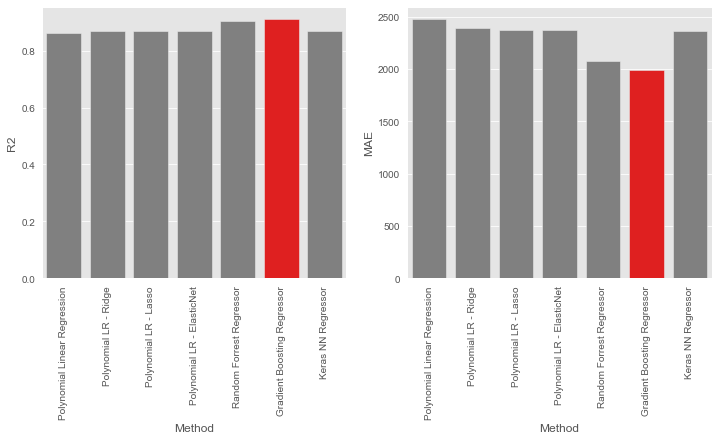

In [66]:
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.subplot(121)

values = df_models['R2']  
idx = df_models.index

clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sns.barplot(x=idx, y=values, palette=clrs)
plt.ylabel('R2')
plt.xlabel('Method')
plt.xticks(rotation=90)


plt.subplot(122)

values2 = df_models['MAE']  
idx2 = df_models.index

clrs = ['grey' if (x > min(values2)) else 'red' for x in values2 ]
sns.barplot(x=idx, y=values2, palette=clrs)
plt.xticks(rotation=90)
plt.ylabel('MAE')
plt.xlabel('Method')

plt.show()

In [72]:
# mae as % of mean price_eur 
metrics.mean_absolute_error(y_test, gbr_7.predict(X_test))/y_test.mean()

0.15877622958863108

# Project summary

<b> On the 50 000 car dataset that was sampled from cleaned dataset I managed to reach: <font color=blue> 91% R2 score and 1988 of MAE </font>.
This means that our predicions vary from real prices about nearly EUR 2000 on average, which is some 16%.</b>


Gradient Boosting Regressor proved to be the best algorithm out of the methods checked. The second one was Random Forest Regressor. Keras Neural Network did not work that well on the dataset and its prediction accuracy was as alike to different Polynomial Regression regulatization methods. Since SVR was very slow, I decided to drop it from the algorithm competition (12 hours was still not enough to train the model on the sample dataset). 

It is still not perfect, but it is more than I expected. After cleaning the dataset, knowing how data is messed, I was very anxious how my modelling will perform. Real data is far more challenging than ordinary, ready-to-use datasets that I got used to during my bootcamp clasesss.
        
Moreover the project proved that when a categorical variable is inbalanced (such as it was a case in 'cluster', 'seat_number', or 'door_number') and as it is not directly correlated with target variable, it increases the model clomplexity, not bringing better prediction accuracy in return. As in ML no holds are barred, sometimes no variable preprocessing at all can bring out better results (as I decided to remove One Hot Encoding for the ordinal cariables 'seat_number' or 'door_number' from regression models).
   
There is still a place to improve by tunning up models. This will be performed later on as a supplement to this project as I need to get my Laptop rest after a series of busy days.

### Comparing predicted prices to real car ad prices

In [73]:
price_predictions = pd.DataFrame(gbr_7.predict(X).round(), columns=['predicted_price_eur'])

In [74]:
df = df[['price_eur', 'maker', 'model', 'age_years',
         'mileage', 'engine_displacement', 'engine_power', 'transmission', 'cluster']]

In [75]:
frames = [price_predictions, df]
df_with_predictions = pd.concat(frames, axis=1)
df_with_predictions.head(20)

,predicted_price_eur,price_eur,maker,model,age_years,mileage,engine_displacement,engine_power,transmission,cluster
0,10958.0,11900.00,seat,altea,5.0,89000.0,1598.0,103.258701,0,11
1,9236.0,7500.00,ford,focus,5.0,100000.0,1560.0,107.281767,0,11
2,4514.0,2900.00,suzuki,swift,9.0,163000.0,1248.0,68.392127,0,6
3,11901.0,12900.00,mercedes-benz,vito,6.0,112561.0,2148.0,93.871546,0,8
4,53965.0,58004.00,porsche,panamera,2.0,41059.0,2967.0,296.365882,1,7
5,8365.0,10499.00,peugeot,3008,6.0,100000.0,1560.0,107.281767,0,11
6,10486.0,9011.66,skoda,octavia,4.0,154784.0,1390.0,120.691988,0,1
7,6289.0,6500.00,toyota,iq,6.0,68000.0,998.0,67.051104,1,6
8,11649.0,11500.00,citroen,c5,4.0,119683.0,1560.0,112.645855,0,1
9,19562.0,13392.49,hyundai,ix35,1.0,15.0,1599.0,132.761187,0,1


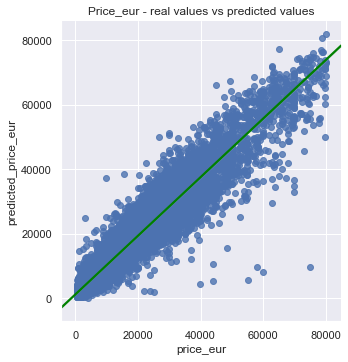

In [78]:
sns.set()
sns.lmplot(x='price_eur', y='predicted_price_eur', data=df_with_predictions, line_kws={'color': 'green'})
plt.title('Price_eur - real values vs predicted values')
plt.show()